In [157]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit_algorithms.utils import algorithm_globals
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import sklearn.metrics.cluster as cluster_metrics
import numpy as np
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.circuit.library import RawFeatureVector
from sklearn.manifold import TSNE
from qiskit.circuit.library import RealAmplitudes, TwoLocal
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pickle
from sklearn.cluster import AgglomerativeClustering, KMeans
import torch
from torch import nn
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN
from torchsummary import summary
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import datasets
import math

# SEED

Configuration of the random seed for experimental reproducibility.

In [158]:
# Set all needed seeds
import random
import numpy as np
import torch
import os

def set_seed(seed=42):
    """
    Set seed for reproducibility across all random number generators.
    
    Args:
        seed (int): Seed value for reproducibility
    """
    # Python random module
    random.seed(seed)
    
    # NumPy random generator
    np.random.seed(seed)
    
    # PyTorch random generator
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # CUDA deterministic operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Qiskit determinism
    algorithm_globals.random_seed = seed
    
    # Python hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

# UTILITIES

Utility functions for metrics evaluation and environment management.

In [159]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print(f"CUDA Available: {torch.cuda.is_available()}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using {color.BOLD}{str(device).upper()}{color.END} acceleration")

CUDA Available: True
Using CUDA acceleration


In [160]:
def purity_score(y_true, y_pred):
    """
    Compute the purity score for clustering evaluation.
    
    Args:
        y_true: Ground truth labels
        y_pred: Predicted cluster labels
    
    Returns:
        float: Purity score
    """
    contingency_matrix = cluster_metrics.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

def evaluate_clustering(X, pred_y, true_y):
    """
    Evaluate clustering performance using silhouette and purity metrics.
    
    Args:
        X: Feature matrix
        pred_y: Predicted cluster labels
        true_y: Ground truth labels
    """
    print(f"Silhouette: {silhouette_score(X, pred_y):2.3f}")
    print(f"Purity: {purity_score(true_y, pred_y):2.3f}")

def evaluate_clustering_table(X, pred_y, true_y):
    """
    Evaluate clustering performance and return metrics as tuple.
    
    Args:
        X: Feature matrix
        pred_y: Predicted cluster labels
        true_y: Ground truth labels
    
    Returns:
        tuple: (silhouette_score, purity_score)
    """
    return silhouette_score(X, pred_y), purity_score(true_y, pred_y)

# DATASET IMPORT

Dataset importation and configuration for training and testing procedures.

In [161]:
# ===========================
# DATASET CONFIGURATION
# ===========================
# Select dataset: "MNIST" or "FashionMNIST"
DATASET_TYPE = "MNIST"  # Change to "FashionMNIST" to use Fashion-MNIST

INITIAL_TRAINING_SAMPLES = 400


MNIST_base_transform = transforms.Compose([
transforms.ToTensor()
])

# Dataset loading based on configuration
if DATASET_TYPE == "MNIST":
    MNIST_dataset_train = datasets.MNIST(root="quantum_metric_learning-master/data/dataset/MNIST", train=True, download=True, transform=MNIST_base_transform)
    MNIST_dataset_test = datasets.MNIST(root="quantum_metric_learning-master/data/dataset/MNIST", train=False, download=True, transform=MNIST_base_transform)
    print(f"{color.BOLD}Using MNIST dataset{color.END}")
elif DATASET_TYPE == "FashionMNIST":
    MNIST_dataset_train = datasets.FashionMNIST(root="quantum_metric_learning-master/data/dataset/FashionMNIST", train=True, download=True, transform=MNIST_base_transform)
    MNIST_dataset_test = datasets.FashionMNIST(root="quantum_metric_learning-master/data/dataset/FashionMNIST", train=False, download=True, transform=MNIST_base_transform)
    print(f"{color.BOLD}Using Fashion MNIST dataset{color.END}")
else:
    raise ValueError(f"Unknown dataset type: {DATASET_TYPE}. Choose 'MNIST' or 'FashionMNIST'")

if False:
    index01 = MNIST_dataset_train.train_labels <= 1
    MNIST_dataset_train.data = MNIST_dataset_train.data[index01]
    MNIST_dataset_train.targets = MNIST_dataset_train.targets[index01]

    index01_test = MNIST_dataset_test.train_labels <= 1
    MNIST_dataset_test.data = MNIST_dataset_test.data[index01_test]
    MNIST_dataset_test.targets = MNIST_dataset_test.targets[index01_test]

print(f"FULL DATASET INFORMATION")
print(f"Image shape: {MNIST_dataset_train.data.shape}")
print(f"Total training samples: {len(MNIST_dataset_train)}")
print(f"Total test samples: {len(MNIST_dataset_test)}")
print("")

init_train_data, _, init_train_target, _ = train_test_split(
    range(len(MNIST_dataset_train)), 
    MNIST_dataset_train.targets,
    random_state=42,
    stratify=MNIST_dataset_train.targets,
    test_size=len(MNIST_dataset_train)- INITIAL_TRAINING_SAMPLES)

X = MNIST_dataset_train.data[init_train_data].numpy().astype("float32") / 255
y = MNIST_dataset_train.targets[init_train_data].numpy().astype("float32") 

print("TRAINING DATA INFORMATION")
print(f"Image shape: {X.shape}")
print(f"Total training samples: {len(X)}")
print("")

'''
init_test_data, _, init_test_target, _ = train_test_split(
    range(len(MNIST_dataset_test)), 
    MNIST_dataset_test.targets,
    random_state=42,
    stratify=MNIST_dataset_test.targets,
    test_size=len(MNIST_dataset_test)- INITIAL_TESTING_SAMPLES)
'''

X_test = MNIST_dataset_test.data.numpy().astype("float32") / 255
y_test = MNIST_dataset_test.targets.numpy().astype("float32")

print("TESTING DATA INFORMATION")
print(f"Image shape: {X_test.shape}")
print(f"Total test samples: {len(X_test)}")
print("")

Using MNIST dataset
FULL DATASET INFORMATION
Image shape: torch.Size([60000, 28, 28])
Total training samples: 60000
Total test samples: 10000

TRAINING DATA INFORMATION
Image shape: (400, 28, 28)
Total training samples: 400

TESTING DATA INFORMATION
Image shape: (10000, 28, 28)
Total test samples: 10000



In [162]:
class MNIST_Distance_Dataset_Triplet_Loss(Dataset):
    """
    PyTorch Dataset for triplet loss learning on MNIST-like datasets.
    
    Generates triplets (anchor, positive, negative) for metric learning,
    where positive samples share the same class as anchor, while negative
    samples belong to different classes.
    
    Args:
        data: Image data array
        target: Label array
    """
    def __init__(self, data, target):
        self.data = data
        self.target = target
        self.kers = np.ones((self.data.shape[0], self.data.shape[0]))
        self.output_transform = transforms.ToTensor()
        self.len = len(self.target)
        self.classes = {i:(np.where(self.target == i)[0], np.where(self.target != i)[0] ) for i in range(10)}


    def __getitem__(self, idx):
        """
        Returns a triplet: (anchor, positive, negative).
        
        Args:
            idx: Index of the anchor sample
        
        Returns:
            tuple: (anchor, positive, negative) samples
        """
        return self.get_anchor(idx), self.get_positive(idx), self.get_negative(idx)
    
    def get_anchor(self, idx):
        """Returns the anchor sample."""
        return self.output_transform(self.data[idx])
    

    def get_positive(self, idx):
        """Returns a positive sample (same class as anchor)."""
        i = np.random.choice(self.classes[self.target[idx]][0])
        return self.output_transform(self.data[i])
    
    def get_negative(self, idx):
        """Returns a negative sample (different class from anchor)."""
        i = np.random.choice(self.classes[self.target[idx]][1])
        return self.output_transform(self.data[i])


    def get_order(self):
        """Returns the sorting order of samples by label."""
        return self.target.argsort()


    def ordered_pairwise(self):
        """Returns ordered pairwise kernel matrix."""
        return self.kers[:,self.get_order()][self.get_order(),:]


    def get_flatten(self):
        """Returns flattened image data."""
        return self.data.reshape((self.data.shape[0], self.data.shape[1]**2))


    def __len__(self):
        """Returns the total number of samples."""
        return self.len

Training set size: 300
Validation set size: 100


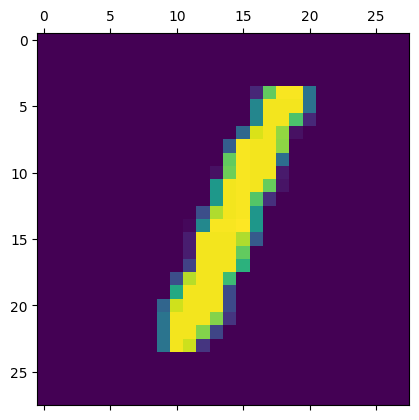

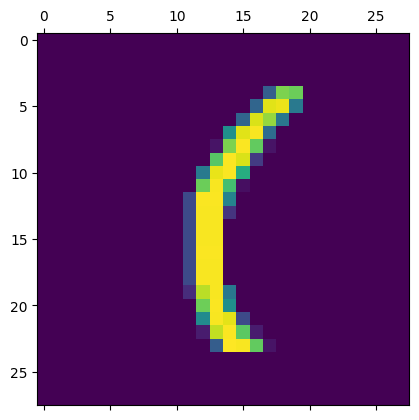

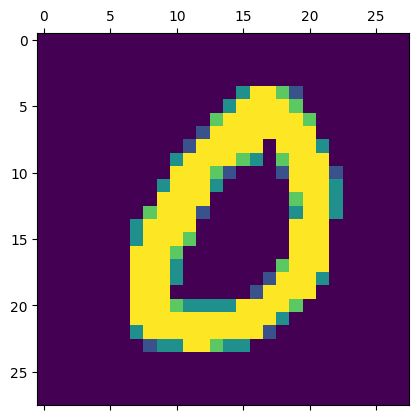

In [163]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
t = MNIST_Distance_Dataset_Triplet_Loss(X_train, y_train)
v = MNIST_Distance_Dataset_Triplet_Loss(X_val, y_val)

print(f"Training set size: {len(t)}")
print(f"Validation set size: {len(v)}")

anchor, pos, neg = t[0]

plt.matshow(anchor.squeeze(0))
plt.matshow(pos.squeeze(0))
plt.matshow(neg.squeeze(0))

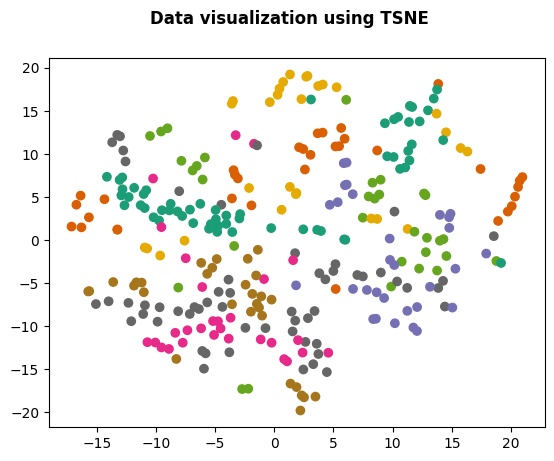

In [164]:
reduction_model = TSNE(n_components=2, perplexity=30, random_state=42)

vis_x = reduction_model.fit_transform(t.get_flatten(), t.target)

fig, ax = plt.subplots()
fig.suptitle("Data visualization using TSNE", weight="bold")
ax.scatter(vis_x[:,0], vis_x[:,1], c=t.target, cmap='Dark2')

# ENCODERS

Definition of encoding strategies for data representation in quantum circuits.

### Amplitude encoding

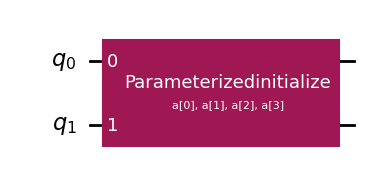

In [165]:
def amplitude_encoding(n_features, param_name):
    """
    Amplitude encoding: requires n = 2^k features.
    
    Args:
        n_features: Number of features to encode
        param_name: Name for the parameter vector
    
    Returns:
        QuantumCircuit: Amplitude encoding circuit
    """
    qc = RawFeatureVector(n_features)
    qc = qc.assign_parameters(ParameterVector(param_name, n_features))
    qc.name = f"Amplitude Encoding {param_name}"
    return qc

amplitude_encoding(4, "a").draw(output="mpl")

### YZ angles encoding

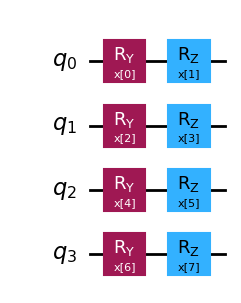

In [166]:
def yz_angles_encoding(n_features, param_name="x", params=None):
    """
    YZ angles encoding using RY and RZ rotations.
    
    Args:
        n_features: Number of features to encode
        param_name: Parameter vector name (creates new ParameterVector)
        params: Existing ParameterVector to reuse
    
    Note: Specify only one of param_name or params
    
    Returns:
        QuantumCircuit: YZ encoding circuit
    """
    if params is None:
        params = ParameterVector(param_name, n_features)
    
    n_qubit = math.ceil(n_features / 2)
    qc = QuantumCircuit(n_qubit, name=f"Angles Encoding")
    gates = [qc.ry, qc.rz]

    for i in range(n_qubit):
        for gate_i in range(2):
            pindex = i*2 + gate_i
            if pindex < n_features:
                gates[gate_i](params[pindex], i)

    return qc

yz_angles_encoding(8, param_name="x").draw(output="mpl")

### Pooling layer

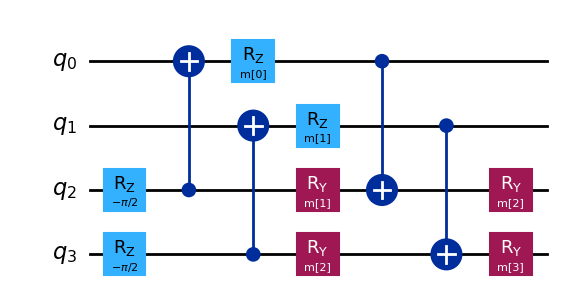

In [167]:
def pooling_layer(in_lane, param_prefix="pool"):
    """
    Pooling layer for quantum circuit dimensionality reduction.
    
    Args:
        in_lane: Number of input qubits (must be even)
        param_prefix: Prefix for parametrized gates
    
    Returns:
        QuantumCircuit: Pooling layer circuit
    """
    qc = QuantumCircuit(in_lane, name="Pooling Layer")
    params = ParameterVector(param_prefix, length=in_lane //2 *3)

    for i in range(in_lane//2):
        current = i
        aux = i+ in_lane//2

        base_param =  current*(in_lane//2 -1)

        qc.rz(-np.pi/2, aux)
        qc.cx(aux, current)
        qc.rz(params[base_param + 0], current)
        qc.ry(params[base_param + 1], aux)
        qc.cx(current, aux)
        qc.ry(params[base_param + 2], aux)

    return qc

pooling_layer(4, param_prefix="m").draw(output="mpl")

# ENCODING VARIATIONS

Alternative encoding strategies and variations for advanced experiments.

### HRyRx encoding

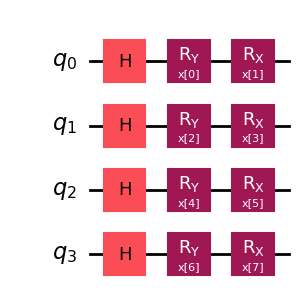

In [168]:
def hRyRx_encoding(n_features):
    """
    Hadamard-RY-RX encoding strategy.
    
    Applies Hadamard gate followed by RY and RX rotations on each qubit.
    
    Args:
        n_features: Number of features to encode (must be even)
    
    Returns:
        QuantumCircuit: HRyRx encoding circuit
    """
    # Number of qubits required
    n_qubits = math.floor(n_features /2) + (1 if (n_features % 2) != 0 else 0)
    # Feature vector from neural network
    n_feature = n_features
    feature_map = QuantumCircuit(n_qubits)
    input_params = ParameterVector(name='x', length=n_feature)
    idx = 0
    for i in range(n_qubits):
        feature_map.h(i)
        feature_map.ry(input_params[idx], i)
        feature_map.rx(input_params[idx+1], i)
        idx +=2

    return feature_map

hRyRx_encoding(8).draw(output="mpl")

### HRyRz encoding

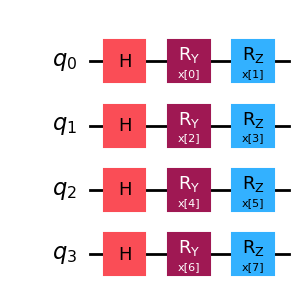

In [169]:
def hRyRz_encoding(n_features):
    """
    Hadamard-RY-RZ encoding strategy.
    
    Applies Hadamard gate followed by RY and RZ rotations on each qubit.
    
    Args:
        n_features: Number of features to encode (must be even)
    
    Returns:
        QuantumCircuit: HRyRz encoding circuit
    """
    # Number of qubits required
    n_qubits = math.floor(n_features /2) + (1 if (n_features % 2) != 0 else 0)
    # Feature vector from neural network
    n_feature = n_features
    feature_map = QuantumCircuit(n_qubits)
    input_params = ParameterVector(name='x', length=n_feature)
    idx = 0
    for i in range(n_qubits):
        feature_map.h(i)
        feature_map.ry(input_params[idx], i)
        feature_map.rz(input_params[idx+1], i)
        idx +=2
    return feature_map

hRyRz_encoding(8).draw(output="mpl")

### X angles encoding

Feature encoding through RX rotations applied to each qubit.

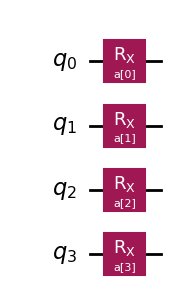

In [170]:
def x_angles_encoding(n_features, param_name):
    """
    X angles encoding using RX rotations.
    
    Args:
        n_features: Number of features to encode
        param_name: Name for the parameter vector
    
    Returns:
        QuantumCircuit: RX encoding circuit
    """
    params = ParameterVector(param_name, n_features)
    n_qubit = n_features
    qc = QuantumCircuit(n_qubit, name=f"Angles Encoding {param_name}")
    

    for i in range(n_qubit):
        qc.rx(params[i], i)

    return qc

x_angles_encoding(4, "a").draw(output="mpl")

### RxRy encoding

Feature encoding through alternating RX and RY rotations.

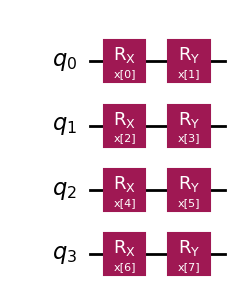

In [171]:
def RxRy_encoding(n_features, params=None):
    """
    RxRy encoding using RX and RY rotations.
    
    Args:
        n_features: Number of features to encode
        params: ParameterVector to use (if None, creates new with name 'x')
    
    Returns:
        QuantumCircuit: RxRy encoding circuit
    """
    if params is None:
        params = ParameterVector(name='x', length=n_features)
    
    n_qubits = math.ceil(n_features / 2)
    feature_map = QuantumCircuit(n_qubits)
    idx = 0
    
    for i in range(n_qubits):
        if idx < n_features:
            feature_map.rx(params[idx], i)
        if idx + 1 < n_features:
            feature_map.ry(params[idx + 1], i)
        idx += 2
    
    return feature_map

RxRy_encoding(8).draw(output="mpl")

### RxRz encoding

Feature encoding through alternating RX and RZ rotations.

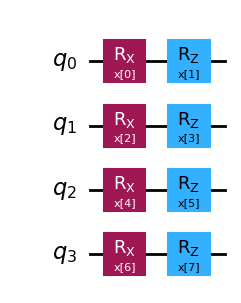

In [172]:
def RxRz_encoding(n_features, params=None):
    """
    RxRz encoding using RX and RZ rotations.
    
    Args:
        n_features: Number of features to encode
        params: ParameterVector to use (if None, creates new with name 'x')
    
    Returns:
        QuantumCircuit: RxRz encoding circuit
    """
    if params is None:
        params = ParameterVector(name='x', length=n_features)
    
    n_qubits = math.ceil(n_features / 2)
    feature_map = QuantumCircuit(n_qubits)
    idx = 0
    
    for i in range(n_qubits):
        if idx < n_features:
            feature_map.rx(params[idx], i)
        if idx + 1 < n_features:
            feature_map.rz(params[idx + 1], i)
        idx += 2
    
    return feature_map

RxRz_encoding(8).draw(output="mpl")

### RyRx encoding

Feature encoding through alternating RY and RX rotations.

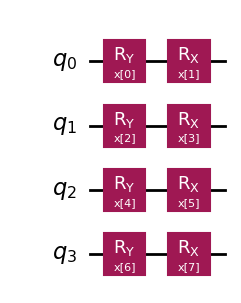

In [173]:
def RyRx_encoding(n_features, params=None):
    """
    RyRx encoding using RY and RX rotations.
    
    Args:
        n_features: Number of features to encode
        params: ParameterVector to use (if None, creates new with name 'x')
    
    Returns:
        QuantumCircuit: RyRx encoding circuit
    """
    if params is None:
        params = ParameterVector(name='x', length=n_features)
    
    n_qubits = math.ceil(n_features / 2)
    feature_map = QuantumCircuit(n_qubits)
    idx = 0
    
    for i in range(n_qubits):
        if idx < n_features:
            feature_map.ry(params[idx], i)
        if idx + 1 < n_features:
            feature_map.rx(params[idx + 1], i)
        idx += 2
    
    return feature_map

RyRx_encoding(8).draw(output="mpl")

### RzRx encoding

Feature encoding through alternating RZ and RX rotations.

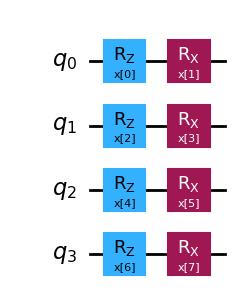

In [174]:
def RzRx_encoding(n_features, params=None):
    """
    RzRx encoding using RZ and RX rotations.
    
    Args:
        n_features: Number of features to encode
        params: ParameterVector to use (if None, creates new with name 'x')
    
    Returns:
        QuantumCircuit: RzRx encoding circuit
    """
    if params is None:
        params = ParameterVector(name='x', length=n_features)
    
    n_qubits = math.ceil(n_features / 2)
    feature_map = QuantumCircuit(n_qubits)
    idx = 0
    
    for i in range(n_qubits):
        if idx < n_features:
            feature_map.rz(params[idx], i)
        if idx + 1 < n_features:
            feature_map.rx(params[idx + 1], i)
        idx += 2
    
    return feature_map

RzRx_encoding(8).draw(output="mpl")

### Nonlinear full entanglement encoding

Feature map with nonlinearity and full entanglement structure among qubits.

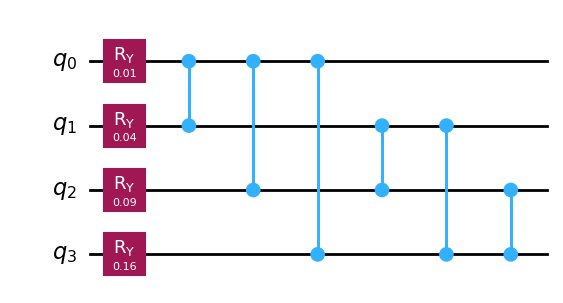

In [175]:
def feature_map_nonlinear_full_entaglement(num_features, params):
    """
    Feature map with nonlinearity (quadratic) and full entanglement.
    
    Args:
        num_features: Number of features to encode
        params: Parameter values for encoding
    
    Returns:
        QuantumCircuit: Nonlinear fully entangled feature map
    """
    qc = QuantumCircuit(num_features)
    for i in range(num_features):
        qc.ry(params[i] ** 2, i)
    for i in range(num_features):
        for j in range(i + 1, num_features):
            qc.cz(i, j)
    return qc

feature_map_nonlinear_full_entaglement(4, [0.1, 0.2, 0.3, 0.4]).draw(output='mpl')

### Standard Reuploading Encoding

Standard encoding scheme with cyclic reuploading of features.

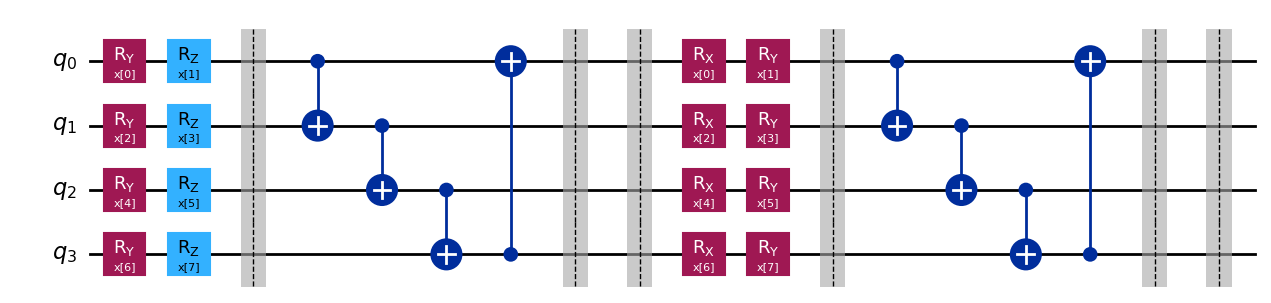

In [176]:
def standard_reuploading_encoding(n_features, param_name="x", layers=3):
    """
    Standard Data Reuploading: data is loaded multiple times into the circuit
    in successive layers with different encodings and entanglement.
    Only encoding and CNOT gates, no ansatz.
    
    Structure (repeating cycle):
    - Layer 0, 3, 6, ...: yz_angles_encoding (RY, RZ)
    - Layer 1, 4, 7, ...: RxRy_encoding (RX, RY)
    - Layer 2, 5, 8, ...: RzRx_encoding (RZ, RX)
    
    Args:
        n_features: Number of input features
        param_name: Parameter name
        layers: Number of reuploading layers (default=3)
    
    Returns:
        QuantumCircuit: Standard reuploading circuit
    """
    n_qubits = math.ceil(n_features / 2)
    qc = QuantumCircuit(n_qubits, name=f"Standard Reuploading")
    params = ParameterVector(param_name, n_features)
    
    for layer in range(layers):
        # Encoder sequence repeats cyclically
        encoder_choice = layer % 3
        
        if encoder_choice == 0:
            # YZ encoding (RY, RZ)
            encoder_block = yz_angles_encoding(n_features, params=params)
                
        elif encoder_choice == 1:
            # RX-RY encoding (RX, RY)
            encoder_block = RxRy_encoding(n_features, params=params)
                
        else:
            # RZ-RX encoding (RZ, RX)
            encoder_block = RzRx_encoding(n_features, params=params)

        qc.compose(encoder_block, inplace=True)
        qc.barrier()
        
        # Entanglement layer with CNOT gates
        for i in range(n_qubits - 1):
            qc.cx(i, i + 1)
        
        # Circular entanglement
        if n_qubits > 2:
            qc.cx(n_qubits - 1, 0)
        
        qc.barrier()
        qc.barrier()
    
    return qc

# Circuit test
standard_reuploading_encoding(8, param_name="x", layers=2).draw(output="mpl")

### Partial Reuploading Encoding

Encoding scheme with partial reuploading and sliding window mechanism.

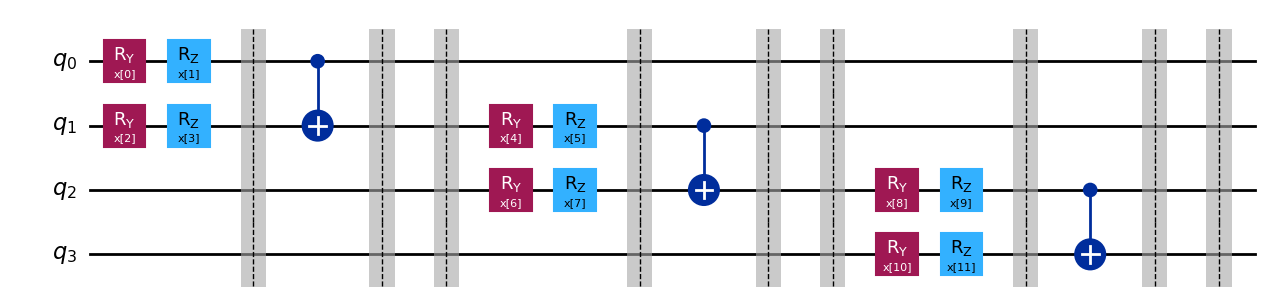

In [177]:
def partial_reuploading_encoding(n_features, layers=3, features_per_layer=4):
    """
    Partial Data Reuploading with sequential sliding window and cyclic wrapping.
    Each layer loads DIFFERENT features on overlapping qubits sequentially.
    The feature cycle is determined by layers * features_per_layer and restarts.
    Only encoding (RY, RZ) and entanglement (CNOT), no ansatz.
    
    Example with 3 layers, 4 features/layer:
    - Layer 0: features 0-3  → qubits (0,1)
    - Layer 1: features 4-7  → qubits (1,2)  
    - Layer 2: features 0-3  → qubits (2,3)  [restarts from beginning]
    Total cycle: 8 features, independent of n_features
    
    Args:
        n_features: TOTAL number of available features (must be >= features_per_layer)
        layers: Number of encoding blocks
        features_per_layer: How many features to load in each layer (must be even)
    
    Returns:
        QuantumCircuit: Partial reuploading sequential with wrapping
    """
    # Ensure features_per_layer is even
    if features_per_layer % 2 != 0:
        features_per_layer += 1
        print(f"Adjusted features_per_layer to {features_per_layer} for pair encoding.")
    
    # Calculate total feature cycle (independent of n_features)
    total_cycle = layers * features_per_layer
    
    # Ensure n_features is sufficient for one cycle iteration
    if n_features < features_per_layer:
        raise ValueError(f"n_features ({n_features}) must be >= features_per_layer ({features_per_layer})")
    
    # Calculate number of qubits needed for sliding window
    n_qubits_per_encoding = math.ceil(features_per_layer / 2)
    n_qubits = n_qubits_per_encoding + (layers - 1)
    
    # Initialize circuit with cycle independent of n_features
    qc = QuantumCircuit(n_qubits, name="Partial Reuploading Sequential")
    input_params = ParameterVector("x", total_cycle)
    
    for layer in range(layers):
        # Calculate qubit offset for this layer (sliding window)
        qubit_offset = layer
        
        # Calculate starting feature index for this layer (cycles over total_cycle)
        start_feature_idx = (layer * features_per_layer) % total_cycle
        
        # Load feature block onto current window qubits with cyclic wrapping
        feature_idx = 0
        for i in range(n_qubits_per_encoding):
            qubit_target = qubit_offset + i
            
            # Calculate feature indices with cyclic wrapping over total_cycle
            p_idx_1 = (start_feature_idx + feature_idx) % total_cycle
            p_idx_2 = (start_feature_idx + feature_idx + 1) % total_cycle
            
            # Apply encoding gates
            qc.ry(input_params[p_idx_1], qubit_target)
            qc.rz(input_params[p_idx_2], qubit_target)
            
            feature_idx += 2

        qc.barrier()
        
        # Entanglement layer on qubits in this layer
        qubits_in_layer = list(range(qubit_offset, qubit_offset + n_qubits_per_encoding))
        for i in range(len(qubits_in_layer) - 1):
            qc.cx(qubits_in_layer[i], qubits_in_layer[i + 1])
        
        # Circular entanglement (optional, only if more than 2 qubits)
        if len(qubits_in_layer) > 2:
            qc.cx(qubits_in_layer[-1], qubits_in_layer[0])
        
        qc.barrier()
        qc.barrier()
    
    return qc

# Circuit test - 8 feature cycle (2 layers * 4 features/layer), same with n_features=24, 12, 8, etc.
partial_reuploading_encoding(n_features=12, layers=3, features_per_layer=4).draw(output="mpl")

# ANSATZ

### MPS


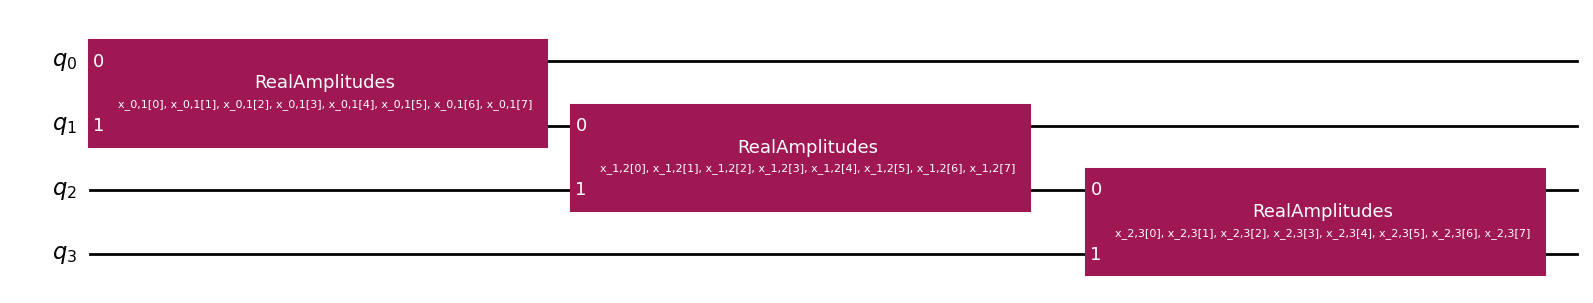

In [178]:
def MPS(num_qubits,parameter_prefix="x", **kwargs):
    """
    Constructs a Matrix Product State (MPS) quantum circuit.

    Args:
        num_qubits (int): The number of qubits in the circuit.
        **kwargs: Additional keyword arguments to be passed to the 
        RealAmplitudes.

    Returns:
        QuantumCircuit: The constructed MPS quantum circuit.
        
    """
    qc = QuantumCircuit(num_qubits)
    qubits = range(num_qubits)
    for i, j in zip(qubits[:-1], qubits[1:]):
        block = RealAmplitudes(2, parameter_prefix=f"{parameter_prefix}_{i},{j}", **kwargs)
        qc.compose(block, [i, j], inplace=True)
        # if i < num_qubits - 2:
        #     qc.barrier()
    return qc

MPS(4).draw('mpl')

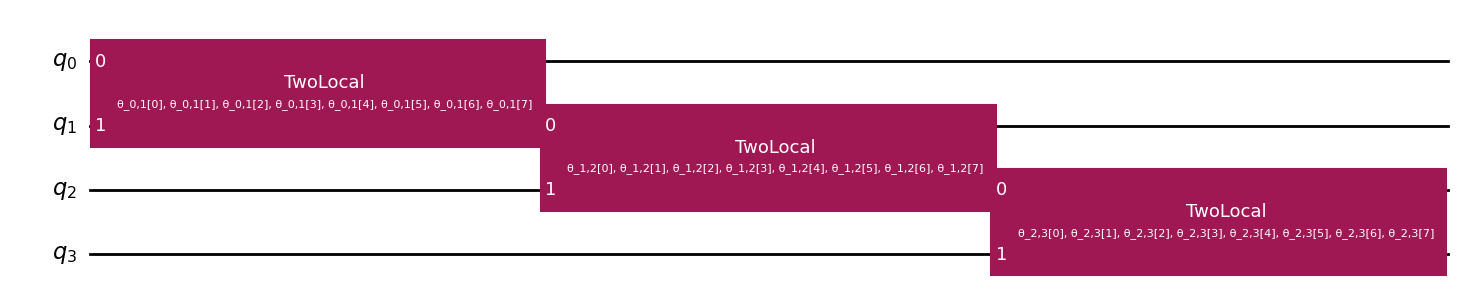

In [179]:
def TwoLocalMPS(num_qubits,parameter_prefix="θ", **kwargs):
    """
    Constructs a Matrix Product State (MPS) quantum circuit using TwoLocal.

    Args:
        num_qubits (int): The number of qubits in the circuit.
        **kwargs: Additional keyword arguments to be passed to TwoLocal.

    Returns:
        QuantumCircuit: The constructed MPS quantum circuit.
        
    """
    qc = QuantumCircuit(num_qubits)
    qubits = range(num_qubits)
    for i, j in zip(qubits[:-1], qubits[1:]):
        block = TwoLocal(
            2,
            rotation_blocks='rx',
            entanglement='reverse_linear',
            entanglement_blocks='cx',
            parameter_prefix=f'{parameter_prefix}_{i},{j}',
            insert_barriers=True,
            **kwargs

        )
        qc.compose(block, [i, j], inplace=True)
    return qc

TwoLocalMPS(4).draw('mpl')

In [180]:
def create_ansatz(num_qubits, parameter_prefix="θ", ansatz_type="MPS", **kwargs):
    """
    Crea un ansatz del tipo specificato.
    
    Args:
        num_qubits (int): Numero di qubit.
        parameter_prefix (str): Prefisso per i parametri.
        ansatz_type (str): Tipo di ansatz - "MPS" (RealAmplitudes) o "TwoLocalMPS" (TwoLocal).
        **kwargs: Argomenti aggiuntivi passati alla funzione ansatz.
    
    Returns:
        QuantumCircuit: Il circuito ansatz.
    """
    if ansatz_type == "MPS":
        return MPS(num_qubits, parameter_prefix=parameter_prefix, **kwargs)
    elif ansatz_type == "TwoLocalMPS":
        return TwoLocalMPS(num_qubits, parameter_prefix=parameter_prefix, **kwargs)
    else:
        raise ValueError(f"Ansatz type '{ansatz_type}' non supportato. Usa 'MPS' o 'TwoLocalMPS'.")

# CIRCUITS

Definizione e composizione dei circuiti quantistici per l'apprendimento.

### Original circuit definition (with RealAmplitudes and Pooling)

Uncomment the necessary encoding to perform specific experiments.

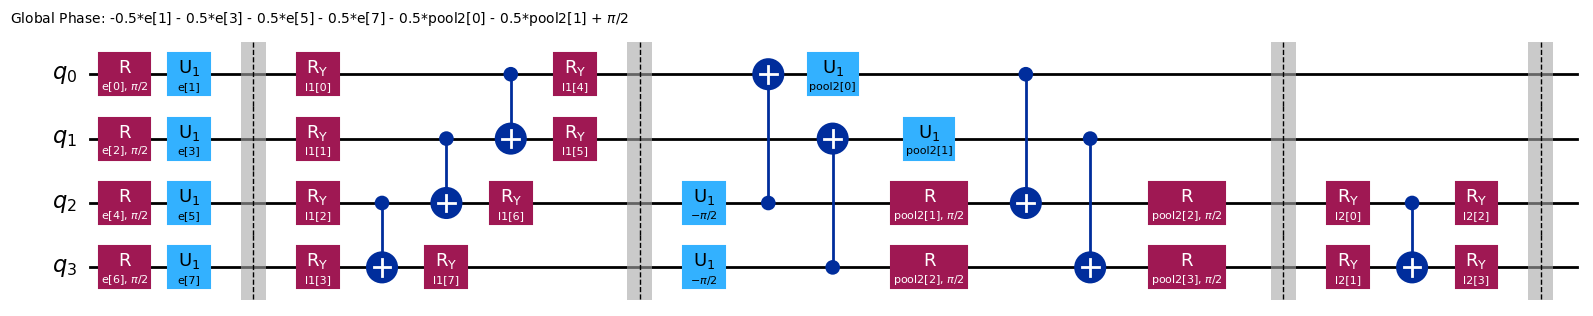

In [181]:
encoding = yz_angles_encoding(8, param_name="e")
#encoding = hRyRx_encoding(8)
#encoding= hRyRz_encoding(8)
#encoding = RyRx_encoding(8)





ansatz = QuantumCircuit(4)
ansatz.barrier()
############################2#######################
ansatz = ansatz.compose(RealAmplitudes(num_qubits=4, reps=1, name="Layer1", parameter_prefix="l1"))
ansatz.barrier()
############################3#######################
ansatz = ansatz.compose(pooling_layer(4, "pool2"))
ansatz.barrier()
############################4#######################
ansatz = ansatz.compose(RealAmplitudes(num_qubits=2, reps=1, name="Layer2",parameter_prefix="l2"), qubits=[2,3])
ansatz.barrier()

ansatz.decompose().draw(output="mpl")


qnn = QuantumCircuit(4).compose(encoding).compose(ansatz)

display(qnn.decompose().draw("mpl"))



### Tensor Network circuit (MPS only)

Example of quantum circuit with pure tensor network (MPS) structure.

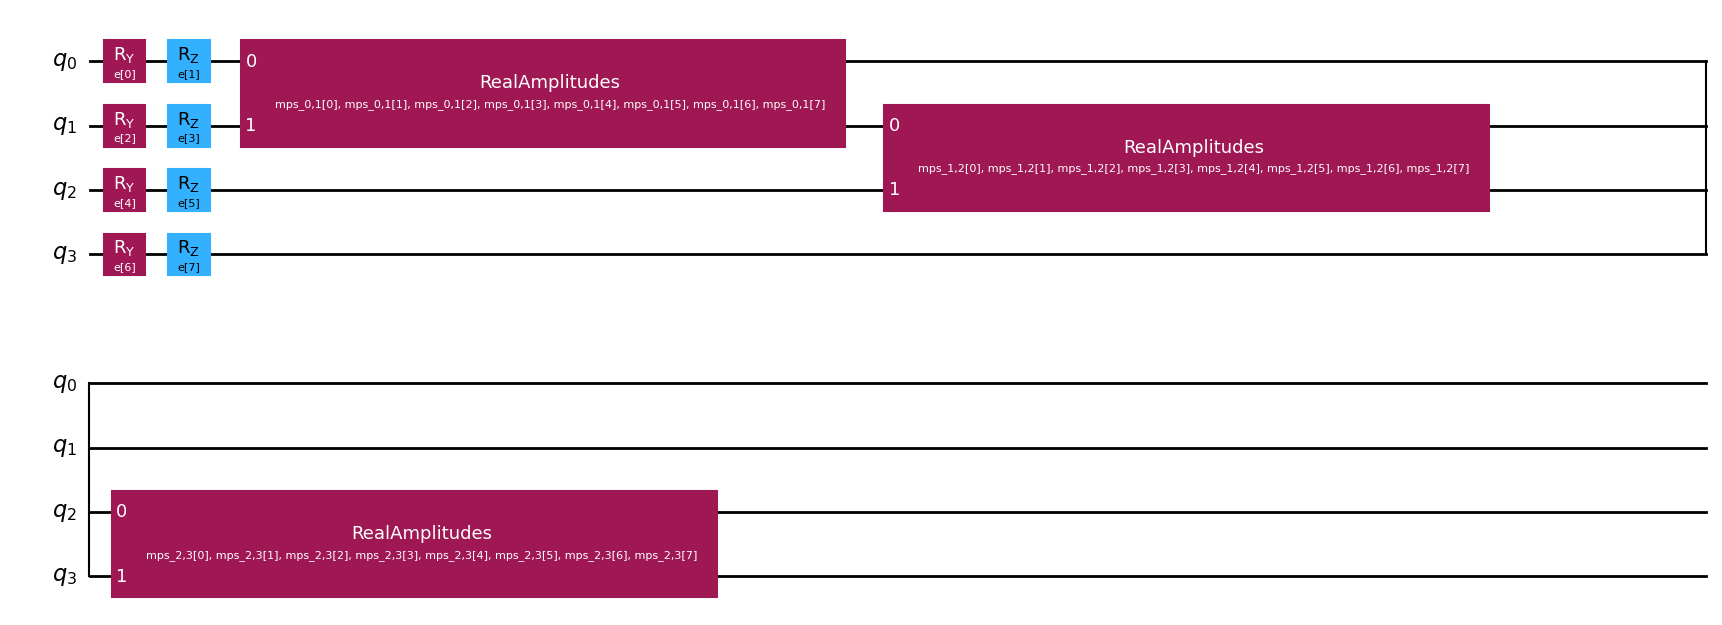

In [182]:
encoding = yz_angles_encoding(8, param_name="e")


qnn = QuantumCircuit(4).compose(encoding)

# Adding MPS to the circuit
ansatz = MPS(num_qubits=4, parameter_prefix="mps")
qnn = qnn.compose(ansatz)

# Circuit visualization
display(qnn.draw("mpl"))

In [183]:
# Display parameter counts for encoding, ansatz, and total circuit
print("Encoding parameters:", len(encoding.parameters))
print("Ansatz parameters:", len(ansatz.parameters))
print("Total circuit parameters:", len(qnn.parameters))

Encoding parameters: 8
Ansatz parameters: 24
Total circuit parameters: 32


### Standard reuploading circuit

Quantum circuit with standard data reuploading for metric learning.

Circuit with encoder sequence: ['yz', 'RxRy'], ansatz: MPS
Encoding parameters: 8
Ansatz parameters: 24
Total parameters: 32


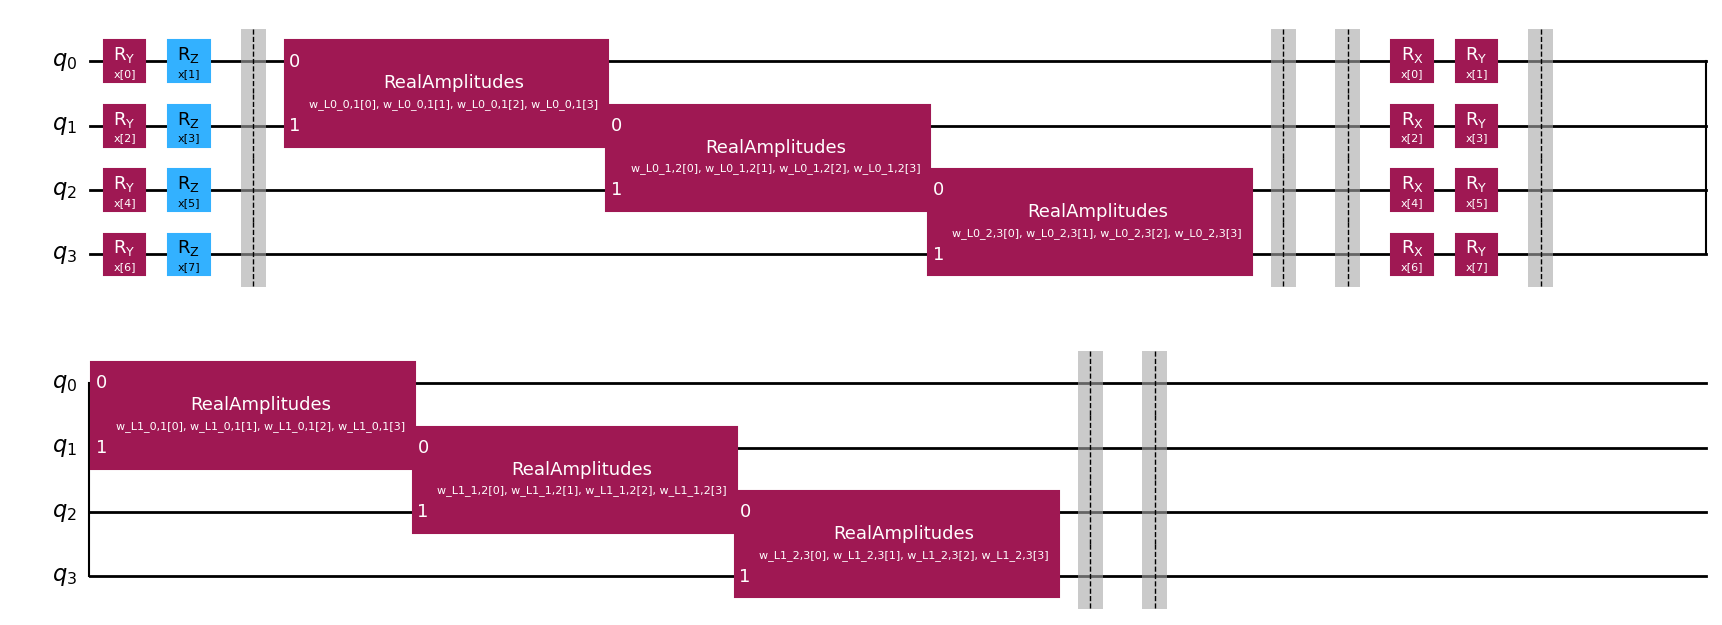

In [184]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes
import math

def build_mps_reuploading_model(n_features, encoder_sequence=None, ansatz_type="MPS", 
                                apply_cnot_after_encoder=None):
    """
    Constructs a modular reuploading classifier with custom encoder sequence and 
    optional CNOT entangling layer between encoder and ansatz.
    
    Args:
        n_features (int): Number of input features.
        encoder_sequence (list): List of encoder names, one per layer.
                                Example: ["yz", "RxRy"] for 2 layers
                                         ["yz", "RxRy", "RzRx"] for 3 layers
                                Supported: "yz", "RxRy", "RxRz", "RyRx", "RzRx"
                                If None, defaults to ["yz", "RxRy"] (2 layers).
        ansatz_type (str): Type of ansatz - "MPS" or "TwoLocalMPS" (default="MPS").
        apply_cnot_after_encoder (list): List of booleans, one per layer, indicating 
                                        whether to apply full CNOT chain after encoder.
                                        Example: [True, False] applies CNOTs only after 
                                        first layer encoder. If None, no CNOTs applied.
    
    Returns:
        QuantumCircuit: Complete reuploading quantum circuit
    
    Examples:
        # Standard: 2 layers without CNOTs
        build_mps_reuploading_model(8, ["yz", "RxRy"], "MPS")
        
        # With CNOTs on first layer only
        build_mps_reuploading_model(8, ["yz", "RxRy"], "MPS", [True, False])
        
        # With CNOTs on all layers
        build_mps_reuploading_model(8, ["yz", "RxRy"], "MPS", [True, True])
    """
    
    # Default encoder sequence
    if encoder_sequence is None:
        encoder_sequence = ["yz", "RxRy"]
    
    # Default CNOT configuration (no CNOTs)
    if apply_cnot_after_encoder is None:
        apply_cnot_after_encoder = [False] * len(encoder_sequence)
    
    # Validate length consistency
    if len(apply_cnot_after_encoder) != len(encoder_sequence):
        raise ValueError(f"apply_cnot_after_encoder length ({len(apply_cnot_after_encoder)}) "
                        f"must match encoder_sequence length ({len(encoder_sequence)})")
    
    # Encoder mapping
    encoder_map = {
        "yz":   yz_angles_encoding,
        "RxRy": RxRy_encoding,
        "RxRz": RxRz_encoding,
        "RyRx": RyRx_encoding,
        "RzRx": RzRx_encoding,
    }
    
    # Validate encoders
    for enc in encoder_sequence:
        if enc not in encoder_map:
            raise ValueError(f"Encoder '{enc}' not supported. "
                           f"Use: {list(encoder_map.keys())}")
    
    # Calculate required number of qubits
    n_qubits = math.ceil(n_features / 2)
    
    # Initialize final circuit
    full_qc = QuantumCircuit(n_qubits, name=f"{ansatz_type} Re-uploading")
    
    # Create input parameters ONCE (shared across all layers)
    input_params = ParameterVector("x", n_features)
    
    # Build circuit: Encoder → [CNOT] → Ansatz for each layer
    for layer, encoder_name in enumerate(encoder_sequence):
        
        # --- A. Add Encoder ---
        encoder_fn = encoder_map[encoder_name]
        if encoder_name == "yz":
            encoder_block = encoder_fn(n_features, params=input_params)
        else:
            encoder_block = encoder_fn(n_features, params=input_params)
        
        full_qc.compose(encoder_block, inplace=True)
        full_qc.barrier()
        
        # --- B. Add CNOT chain (if requested for this layer) ---
        if apply_cnot_after_encoder[layer]:
            # Full CNOT chain: 0→1, 1→2, 2→3, ...
            for qubit in range(n_qubits - 1):
                full_qc.cx(qubit, qubit + 1)
            full_qc.cx(n_qubits - 1, 0)  # Circular entanglement
            full_qc.barrier()
        
        # --- C. Add Ansatz (MPS or TwoLocalMPS) ---
        ansatz_block = create_ansatz(n_qubits, parameter_prefix=f"w_L{layer}", 
                                     ansatz_type=ansatz_type, reps=1)
        full_qc.compose(ansatz_block, inplace=True)
        
        full_qc.barrier()
        full_qc.barrier()

    return full_qc

# --- TEST ---
# Example with 8 features, 2 layers (YZ and RxRy), MPS ansatz, and no CNOTs
ansatz_type = "MPS"
encoder_seq = ["yz", "RxRy"]
qnn_std_reupload = build_mps_reuploading_model(
    n_features=8, 
    encoder_sequence=encoder_seq, 
    ansatz_type=ansatz_type,
    apply_cnot_after_encoder=[False, False]
)

# Display the result
print(f"Circuit with encoder sequence: {encoder_seq}, ansatz: {ansatz_type}")
print("Encoding parameters:", len([p for p in qnn_std_reupload.parameters if p.name.startswith('x')]))
print("Ansatz parameters:", len([p for p in qnn_std_reupload.parameters if p.name.startswith('w')]))
print("Total parameters:", len(qnn_std_reupload.parameters))
qnn_std_reupload.draw(output="mpl")

### Partial reuploading circuit

Quantum circuit with partial data reuploading and sliding window mechanism.

Circuit with encoder: yz, ansatz: RA
Encoding parameters: 12
Ansatz parameters: 12
Total parameters: 24


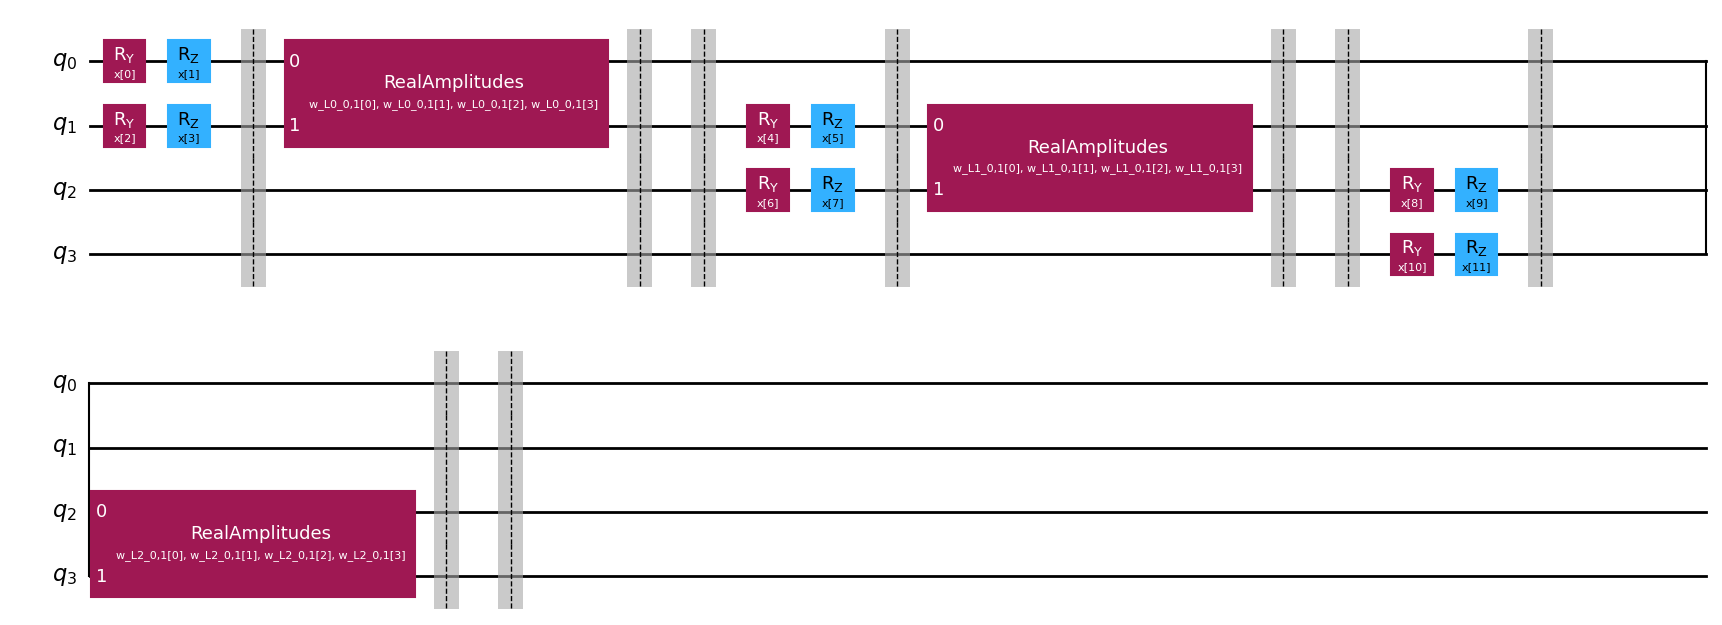

In [185]:
def build_partial_mps_model(n_features, layers=3, features_per_layer=4, fixed_encoder="yz", 
                           ansatz_type="RA", apply_cnot_after_encoder=False):
    """
    Constructs a Sequential Partial classifier with sliding window architecture.
    Each layer loads DIFFERENT features on sequentially overlapping qubits.
    
    Example with 4 qubits, 3 layers, 4 features/layer:
    - Layer 0: features 0-3  → qubits (0,1)
    - Layer 1: features 4-7  → qubits (1,2)  
    - Layer 2: features 8-11 → qubits (2,3)
    Total: 12 features mapped
    
    Args:
        n_features (int): TOTAL number of features to map (increased from standard case).
        layers (int): Number of [Encoding -> Ansatz] blocks.
        features_per_layer (int): How many features to load in each layer (must be even).
        fixed_encoder (str): Encoder to use for all layers.
                            Options: "yz", "RxRy", "RxRz", "RyRx", "RzRx" (default="yz").
        ansatz_type (str): Type of ansatz - "RA" (RealAmplitudes) or "TL" (TwoLocal) (default="RA").
        apply_cnot_after_encoder (bool): If True, applies CNOT chain on populated qubits 
                                        after encoder in all layers (default=False).
    
    Returns:
        QuantumCircuit: Partial reuploading quantum circuit
    """
    
    # Ensure features_per_layer is even
    if features_per_layer % 2 != 0:
        features_per_layer += 1
    
    # Encoder validation
    valid_encoders = {"yz", "RxRy", "RxRz", "RyRx", "RzRx"}
    if fixed_encoder not in valid_encoders:
        raise ValueError(f"Encoder '{fixed_encoder}' not supported. "
                        f"Use: {valid_encoders}")
    
    # Map ansatz type from RA/TL to internal MPS/TwoLocalMPS
    ansatz_map = {"RA": "MPS", "TL": "TwoLocalMPS"}
    if ansatz_type not in ansatz_map:
        raise ValueError(f"Ansatz type '{ansatz_type}' not supported. Use 'RA' or 'TL'.")
    internal_ansatz_type = ansatz_map[ansatz_type]
    
    # Map encoder to gate pairs (gate1, gate2)
    encoder_gates = {
        "yz": ("ry", "rz"),
        "RxRy": ("rx", "ry"),
        "RxRz": ("rx", "rz"),
        "RyRx": ("ry", "rx"),
        "RzRx": ("rz", "rx"),
    }
    gate1_name, gate2_name = encoder_gates[fixed_encoder]
    
    # Calculate number of qubits needed for sliding window
    # First layer uses features_per_layer/2 qubits, then each layer adds 1 qubit
    n_qubits_per_encoding = math.ceil(features_per_layer / 2)
    n_qubits = n_qubits_per_encoding + (layers - 1)
    
    # Calculate total number of features that will be mapped
    total_features_mapped = layers * features_per_layer
    
    # Initialize circuit
    full_qc = QuantumCircuit(n_qubits, name=f"Sequential Sliding Window ({fixed_encoder})")
    input_params = ParameterVector("x", total_features_mapped)
    
    for layer in range(layers):
        
        # --- A. SEQUENTIAL SLIDING WINDOW ENCODER ---
        # Calculate qubit offset for this layer (sliding window)
        qubit_offset = layer
        
        # Calculate starting feature index for this layer (sequential, not cyclic)
        start_feature_idx = layer * features_per_layer
        
        # Load feature block onto current window qubits
        feature_idx = 0
        for i in range(n_qubits_per_encoding):
            qubit_target = qubit_offset + i
            
            p_idx_1 = start_feature_idx + feature_idx
            p_idx_2 = start_feature_idx + feature_idx + 1
            
            # Apply gates only if index is valid
            if p_idx_1 < total_features_mapped:
                getattr(full_qc, gate1_name)(input_params[p_idx_1], qubit_target)
            if p_idx_2 < total_features_mapped:
                getattr(full_qc, gate2_name)(input_params[p_idx_2], qubit_target)
            
            feature_idx += 2
        
        full_qc.barrier()
        
        # --- B. CNOT chain (if requested, only on populated qubits) ---
        if apply_cnot_after_encoder:
            # Apply CNOT chain only on qubits used in this layer
            for i in range(n_qubits_per_encoding - 1):
                control_qubit = qubit_offset + i
                target_qubit = qubit_offset + i + 1
                full_qc.cx(control_qubit, target_qubit)
            full_qc.barrier()
        
        # --- C. ANSATZ (RealAmplitudes or TwoLocal) only on populated qubits in this layer ---
        # Calculate qubits used in this layer
        qubits_in_layer = list(range(qubit_offset, qubit_offset + n_qubits_per_encoding))
        ansatz_block = create_ansatz(n_qubits_per_encoding, parameter_prefix=f"w_L{layer}", 
                                     ansatz_type=internal_ansatz_type, reps=1)
        full_qc.compose(ansatz_block, qubits_in_layer, inplace=True)
        
        full_qc.barrier()
        full_qc.barrier()
    
    return full_qc

# --- TEST ---
# Example with 12 features, 3 layers, 4 features/layer, YZ encoder, RA ansatz, and no CNOTs

ansatz_type = "RA"
fixed_enc = "yz"
qnn_partial_reupload = build_partial_mps_model(
    n_features=12, 
    layers=3, 
    features_per_layer=4, 
    fixed_encoder=fixed_enc, 
    ansatz_type=ansatz_type,
    apply_cnot_after_encoder=False
)

# Display the result
print(f"Circuit with encoder: {fixed_enc}, ansatz: {ansatz_type}")
print("Encoding parameters:", len([p for p in qnn_partial_reupload.parameters if p.name.startswith('x')]))
print("Ansatz parameters:", len([p for p in qnn_partial_reupload.parameters if p.name.startswith('w')]))
print("Total parameters:", len(qnn_partial_reupload.parameters))
qnn_partial_reupload.draw(output="mpl")

# HYBRID NETWORKS

Hybrid architectures combining classical neural networks and quantum models.

### 8-features per image

In [186]:
# ===============================
# QUANTUM MODEL: 8 FEATURES
# ===============================
"""
This block defines the hybrid model for images with 8 extracted features,
combining a classical convolutional neural network and a quantum circuit.
The circuit is constructed using the build_mps_reuploading_model function.
"""

from qiskit.primitives import Sampler
def parity(x):
    """Returns the parity (number of 1-bits) of an integer x."""
    return f"{bin(x)}".count("1")

# Quantum circuit construction for 8 features
# Using encoder sequence: yz → RxRy (default 2-layer config)
qnn_circuit_8 = build_mps_reuploading_model(n_features=8, encoder_sequence=["yz", "RxRy"])

# Parameter separation: first 8 are inputs, remaining are ansatz weights
input_ps_8 = list(qnn_circuit_8.parameters)[:8]
weight_ps_8 = list(qnn_circuit_8.parameters)[8:]

qmodel_8 = SamplerQNN(
    circuit=qnn_circuit_8,
    input_params=input_ps_8,
    weight_params=weight_ps_8,
    input_gradients=True
)

class HybridRegressorConvNet8Features(nn.Module):
    """
    Hybrid neural network combining a classical CNN with a quantum circuit.
    
    Args:
        qm1: Quantum model (SamplerQNN) to connect as a layer.
    """
    def __init__(self, qm1):
        super().__init__()

        # Convolutional blocks for feature extraction
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5)),
            nn.ReLU()
        )

        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU()
        )

        self.conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()

        # Reduction to 8 features for quantum layer
        self.reduction = nn.Sequential(
            nn.Linear(in_features=576, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=8)
        )

        # Output layer (from 16 to 16 qubit outputs)
        self.final = nn.Sequential(
            nn.Linear(in_features=16, out_features=16),
        )

        # Quantum layer connected via TorchConnector
        self.q1 = TorchConnector(qm1)

    def forward(self, x):
        """
        Executes forward pass: feature extraction, reduction, quantum layer, and final output.
        
        Args:
            x: Input tensor (batch of images)
        
        Returns:
            torch.Tensor: Output embeddings
        """
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)

        x = self.flatten(x)
        x = self.reduction(x)

        # Pass through quantum layer and normalization
        x = self.q1(x) * 100
        x = self.final(x)

        return x

# Model instantiation and summary
distance_model_8 = HybridRegressorConvNet8Features(qmodel_8)
distance_model_8 = distance_model_8.to(device)
summary(distance_model_8, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
              ReLU-2           [-1, 32, 24, 24]               0
            Conv2d-3           [-1, 32, 20, 20]          25,632
         MaxPool2d-4           [-1, 32, 10, 10]               0
              ReLU-5           [-1, 32, 10, 10]               0
            Conv2d-6             [-1, 64, 6, 6]          51,264
         MaxPool2d-7             [-1, 64, 3, 3]               0
              ReLU-8             [-1, 64, 3, 3]               0
           Flatten-9                  [-1, 576]               0
           Linear-10                  [-1, 120]          69,240
             ReLU-11                  [-1, 120]               0
           Linear-12                    [-1, 8]             968
   TorchConnector-13                   [-1, 16]              24
           Linear-14                   

### 12-features per image

Architecture and pipeline for images with 12 extracted features.

In [187]:
# ===============================
# QUANTUM MODEL: 12 FEATURES
# ===============================
"""
This block defines the hybrid model for images with 12 extracted features,
combining a classical convolutional neural network and a quantum circuit.
The circuit is constructed using the build_partial_mps_model function.
"""

from qiskit.primitives import Sampler

# Quantum circuit construction for 12 features
qnn_circuit_12 = build_partial_mps_model(n_features=12, layers=3, features_per_layer=4, ansatz_type="RA")

# Parameter separation: first 12 are inputs, remaining are ansatz weights
input_ps_12 = list(qnn_circuit_12.parameters)[:12]
weight_ps_12 = list(qnn_circuit_12.parameters)[12:]

qmodel_12 = SamplerQNN(
    circuit=qnn_circuit_12,
    input_params=input_ps_12,
    weight_params=weight_ps_12,
    input_gradients=True
)

class HybridRegressorConvNet12Features(nn.Module):
    """
    Hybrid neural network combining a classical CNN with a quantum circuit.
    
    Args:
        qm1: Quantum model (SamplerQNN) to connect as a layer.
    """
    def __init__(self, qm1):
        super().__init__()

        # Convolutional blocks for feature extraction
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5)),
            nn.ReLU()
        )

        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU()
        )

        self.conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()

        # Reduction to 12 features for quantum layer
        self.reduction = nn.Sequential(
            nn.Linear(in_features=576, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=12)
        )

        # Output layer (from 16 to 16 qubit outputs)
        self.final = nn.Sequential(
            nn.Linear(in_features=16, out_features=16),
        )

        # Quantum layer connected via TorchConnector
        self.q1 = TorchConnector(qm1)

    def forward(self, x):
        """
        Executes forward pass: feature extraction, reduction, quantum layer, and final output.
        
        Args:
            x: Input tensor (batch of images)
        
        Returns:
            torch.Tensor: Output embeddings
        """
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)

        x = self.flatten(x)
        x = self.reduction(x)

        # Pass through quantum layer and normalization
        x = self.q1(x) * 100
        x = self.final(x)

        return x

# Model instantiation and summary
distance_model_12 = HybridRegressorConvNet12Features(qmodel_12)
distance_model_12 = distance_model_12.to(device)
summary(distance_model_12, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
              ReLU-2           [-1, 32, 24, 24]               0
            Conv2d-3           [-1, 32, 20, 20]          25,632
         MaxPool2d-4           [-1, 32, 10, 10]               0
              ReLU-5           [-1, 32, 10, 10]               0
            Conv2d-6             [-1, 64, 6, 6]          51,264
         MaxPool2d-7             [-1, 64, 3, 3]               0
              ReLU-8             [-1, 64, 3, 3]               0
           Flatten-9                  [-1, 576]               0
           Linear-10                  [-1, 120]          69,240
             ReLU-11                  [-1, 120]               0
           Linear-12                   [-1, 12]           1,452
   TorchConnector-13                   [-1, 16]              12
           Linear-14                   

# TRAINING - Model Training Procedures

Section dedicated to model training and epoch management with standardized output formatting.

## Expressivity Analysis

Expressivity measures how well a parameterized quantum circuit can explore different quantum states. We calculate it using the fidelity distribution between randomly sampled states.

In [188]:
from qiskit.quantum_info import Statevector, state_fidelity
from scipy.stats import kstest
import warnings

def calculate_expressivity(circuit, num_samples=1000, seed=42):
    """
    Calculate the expressivity of a quantum circuit using fidelity distribution.
    
    Expressivity is measured by comparing the distribution of state fidelities 
    to the Haar random distribution. Higher KS statistic indicates lower expressivity.
    
    Args:
        circuit: Parameterized quantum circuit
        num_samples: Number of random parameter samples
        seed: Random seed for reproducibility
    
    Returns:
        dict: Contains fidelities, KS statistic, p-value, and expressivity score
    """
    np.random.seed(seed)
    
    # Get parameter list
    params = list(circuit.parameters)
    num_params = len(params)
    
    if num_params == 0:
        warnings.warn("Circuit has no parameters. Expressivity undefined.")
        return None
    
    # Generate random states
    fidelities = []
    states = []
    
    # Sample random parameter values
    for _ in range(num_samples):
        theta = np.random.uniform(0, 2*np.pi, num_params)
        param_dict = dict(zip(params, theta))
        
        # Bind parameters and get statevector
        bound_circuit = circuit.assign_parameters(param_dict)
        try:
            state = Statevector.from_instruction(bound_circuit)
            states.append(state)
        except Exception as e:
            warnings.warn(f"Could not compute statevector: {e}")
            continue
    
    # Calculate pairwise fidelities
    for i in range(len(states)):
        for j in range(i + 1, min(i + 50, len(states))):  # Limited pairs for efficiency
            fid = state_fidelity(states[i], states[j])
            fidelities.append(fid)
    
    if len(fidelities) < 10:
        warnings.warn("Not enough fidelity samples computed.")
        return None
    
    fidelities = np.array(fidelities)
    
    # Haar random expectation for fidelity distribution
    # For n-dimensional Hilbert space, Haar fidelity follows specific distribution
    n_qubits = circuit.num_qubits
    dim = 2 ** n_qubits
    
    # KS test against uniform distribution (approximation for Haar)
    ks_stat, p_value = kstest(fidelities, 'uniform')
    
    # Expressivity score: lower KS statistic = higher expressivity
    # We invert and normalize: score closer to 1 means high expressivity
    expressivity_score = 1 - ks_stat
    
    return {
        'fidelities': fidelities,
        'mean_fidelity': np.mean(fidelities),
        'std_fidelity': np.std(fidelities),
        'ks_statistic': ks_stat,
        'p_value': p_value,
        'expressivity_score': expressivity_score,
        'num_qubits': n_qubits,
        'num_params': num_params,
        'num_samples': len(states)
    }

In [189]:
def plot_expressivity_results(expressivity_results, title="Circuit Expressivity Analysis"):
    """
    Visualize expressivity analysis results.
    
    Args:
        expressivity_results: Dictionary containing expressivity metrics
        title: Plot title
    """
    if expressivity_results is None:
        print("No results to plot")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Fidelity distribution
    ax1 = axes[0]
    fidelities = expressivity_results['fidelities']
    ax1.hist(fidelities, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
    ax1.axvline(expressivity_results['mean_fidelity'], color='red', 
                linestyle='--', linewidth=2, label=f"Mean: {expressivity_results['mean_fidelity']:.4f}")
    ax1.set_xlabel('Fidelity', fontsize=12)
    ax1.set_ylabel('Density', fontsize=12)
    ax1.set_title('Fidelity Distribution', fontsize=14)
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Plot 2: Summary metrics
    ax2 = axes[1]
    ax2.axis('off')
    
    metrics_text = f"""
    Expressivity Analysis
    {'=' * 40}
    
    Circuit Properties:
    • Qubits: {expressivity_results['num_qubits']}
    • Parameters: {expressivity_results['num_params']}
    • Samples: {expressivity_results['num_samples']}
    
    Fidelity Statistics:
    • Mean: {expressivity_results['mean_fidelity']:.4f}
    • Std: {expressivity_results['std_fidelity']:.4f}
    
    Expressivity Metrics:
    • KS Statistic: {expressivity_results['ks_statistic']:.4f}
    • P-value: {expressivity_results['p_value']:.4e}
    • Expressivity Score: {expressivity_results['expressivity_score']:.4f}
    
    Interpretation:
    • Higher score → Better state space coverage
    • Lower mean fidelity → More diverse states
    """
    
    ax2.text(0.1, 0.5, metrics_text, fontsize=11, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', 
             facecolor='wheat', alpha=0.3))
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig

### Expressivity of the 6 Experiment Architectures

We compute expressivity for each unique circuit architecture used across all experiments:

| # | Schema | Encoder sequence | Ansatz (per layer) | Layers | Features |
|---|--------|------------------|--------------------|--------|----------|
| 1 | Standard | yz → RxRy | MPS (4 qubits) | 2 | 8 |
| 2 | Standard | yz → RxRy | TwoLocalMPS (4 qubits) | 2 | 8 |
| 3 | Standard | RxRz → RxRz | MPS (4 qubits) | 2 | 8 |
| 4 | Partial  | yz (sliding window) | RealAmplitudes (2 qubits) | 3 | 12 |
| 5 | Partial  | yz (sliding window) | TwoLocal (2 qubits) | 3 | 12 |
| 6 | Partial  | RxRz (sliding window) | RealAmplitudes (2 qubits) | 3 | 12 |

**Note:** In the standard configs, the encoder *changes* between layers (yz then RxRy). In the partial configs, the ansatz acts only on the 2 populated qubits per layer (not a full MPS chain).

In [190]:
# Expressivity calculation for all 13 unique experiment architectures
num_samples_exp = 500

expressivity_results = {}

print("Computing expressivity for 13 experiment architectures...")
print("=" * 70)

# ==================================================================
# 1. Standard Reuploading: yz→MPS→RxRy→MPS (2 layers, 8 features)
# ==================================================================
label_1 = "Std: yz→MPS→RxRy→MPS"
print(f"\n1. {label_1}")
circuit_1 = build_mps_reuploading_model(n_features=8, encoder_sequence=["yz", "RxRy"], ansatz_type="MPS")
result_1  = calculate_expressivity(circuit_1, num_samples=num_samples_exp)
if result_1:
    expressivity_results[label_1] = result_1
    print(f"   Score: {result_1['expressivity_score']:.4f}  |  Mean Fid: {result_1['mean_fidelity']:.4f}  |  Params: {result_1['num_params']}")

# ==================================================================
# 2. Standard Reuploading: yz→TwoLocalMPS→RxRy→TwoLocalMPS (2 layers, 8 features)
# ==================================================================
label_2 = "Std: yz→TwoLocalMPS→RxRy→TwoLocalMPS"
print(f"\n2. {label_2}")
circuit_2 = build_mps_reuploading_model(n_features=8, encoder_sequence=["yz", "RxRy"], ansatz_type="TwoLocalMPS")
result_2  = calculate_expressivity(circuit_2, num_samples=num_samples_exp)
if result_2:
    expressivity_results[label_2] = result_2
    print(f"   Score: {result_2['expressivity_score']:.4f}  |  Mean Fid: {result_2['mean_fidelity']:.4f}  |  Params: {result_2['num_params']}")

# ==================================================================
# 3. Standard Reuploading: RxRz→MPS→RxRz→MPS (2 layers, 8 features)
# ==================================================================
label_3 = "Std: RxRz→MPS→RxRz→MPS"
print(f"\n3. {label_3}")
circuit_3 = build_mps_reuploading_model(n_features=8, encoder_sequence=["RxRz", "RxRz"], ansatz_type="MPS")
result_3  = calculate_expressivity(circuit_3, num_samples=num_samples_exp)
if result_3:
    expressivity_results[label_3] = result_3
    print(f"   Score: {result_3['expressivity_score']:.4f}  |  Mean Fid: {result_3['mean_fidelity']:.4f}  |  Params: {result_3['num_params']}")

# ==================================================================
# 4. Standard Reuploading: RxRz→MPS→RyRx→MPS (2 layers, 8 features)
# ==================================================================
label_4 = "Std: RxRz→MPS→RyRx→MPS"
print(f"\n4. {label_4}")
circuit_4 = build_mps_reuploading_model(n_features=8, encoder_sequence=["RxRz", "RyRx"], ansatz_type="MPS")
result_4  = calculate_expressivity(circuit_4, num_samples=num_samples_exp)
if result_4:
    expressivity_results[label_4] = result_4
    print(f"   Score: {result_4['expressivity_score']:.4f}  |  Mean Fid: {result_4['mean_fidelity']:.4f}  |  Params: {result_4['num_params']}")

# ==================================================================
# 5. Standard Reuploading: RxRz→CNOT→MPS→RyRx→MPS (2 layers, 8 features)
# ==================================================================
label_5 = "Std: RxRz→CNOT→MPS→RyRx→MPS"
print(f"\n5. {label_5}")
circuit_5 = build_mps_reuploading_model(n_features=8, encoder_sequence=["RxRz", "RyRx"], ansatz_type="MPS", apply_cnot_after_encoder=[True, False])
result_5  = calculate_expressivity(circuit_5, num_samples=num_samples_exp)
if result_5:
    expressivity_results[label_5] = result_5
    print(f"   Score: {result_5['expressivity_score']:.4f}  |  Mean Fid: {result_5['mean_fidelity']:.4f}  |  Params: {result_5['num_params']}")

# ==================================================================
# 6. Standard Reuploading: RyRx→MPS→RxRz→CNOT→MPS (2 layers, 8 features)
# ==================================================================
label_6 = "Std: RyRx→MPS→RxRz→CNOT→MPS"
print(f"\n6. {label_6}")
circuit_6 = build_mps_reuploading_model(n_features=8, encoder_sequence=["RyRx", "RxRz"], ansatz_type="MPS", apply_cnot_after_encoder=[False, True])
result_6  = calculate_expressivity(circuit_6, num_samples=num_samples_exp)
if result_6:
    expressivity_results[label_6] = result_6
    print(f"   Score: {result_6['expressivity_score']:.4f}  |  Mean Fid: {result_6['mean_fidelity']:.4f}  |  Params: {result_6['num_params']}")

# ==================================================================
# 7. Partial Reuploading (yz) + RealAmplitudes(2), 3 layers, 12 features
# ==================================================================
label_7 = "Partial yz + RealAmplitudes"
print(f"\n7. {label_7}")
circuit_7 = build_partial_mps_model(n_features=12, layers=3, features_per_layer=4,
                                     fixed_encoder="yz", ansatz_type="RA")
result_7  = calculate_expressivity(circuit_7, num_samples=num_samples_exp)
if result_7:
    expressivity_results[label_7] = result_7
    print(f"   Score: {result_7['expressivity_score']:.4f}  |  Mean Fid: {result_7['mean_fidelity']:.4f}  |  Params: {result_7['num_params']}")

# ==================================================================
# 8. Partial Reuploading (yz) + TwoLocal(2), 3 layers, 12 features
# ==================================================================
label_8 = "Partial yz + TwoLocal"
print(f"\n8. {label_8}")
circuit_8 = build_partial_mps_model(n_features=12, layers=3, features_per_layer=4,
                                     fixed_encoder="yz", ansatz_type="TL")
result_8  = calculate_expressivity(circuit_8, num_samples=num_samples_exp)
if result_8:
    expressivity_results[label_8] = result_8
    print(f"   Score: {result_8['expressivity_score']:.4f}  |  Mean Fid: {result_8['mean_fidelity']:.4f}  |  Params: {result_8['num_params']}")

# ==================================================================
# 9. Partial Reuploading (RxRz) + RealAmplitudes(2), 3 layers, 12 features
# ==================================================================
label_9 = "Partial RxRz + RealAmplitudes"
print(f"\n9. {label_9}")
circuit_9 = build_partial_mps_model(n_features=12, layers=3, features_per_layer=4,
                                     fixed_encoder="RxRz", ansatz_type="RA")
result_9  = calculate_expressivity(circuit_9, num_samples=num_samples_exp)
if result_9:
    expressivity_results[label_9] = result_9
    print(f"   Score: {result_9['expressivity_score']:.4f}  |  Mean Fid: {result_9['mean_fidelity']:.4f}  |  Params: {result_9['num_params']}")

# ==================================================================
# 10. Partial Reuploading (RyRz) + CNOT + RealAmplitudes(2), 3 layers, 12 features
# ==================================================================
label_10 = "Partial RyRz + CNOT + RealAmplitudes"
print(f"\n10. {label_10}")
circuit_10 = build_partial_mps_model(n_features=12, layers=3, features_per_layer=4,
                                      fixed_encoder="yz", ansatz_type="RA", apply_cnot_after_encoder=True)
result_10  = calculate_expressivity(circuit_10, num_samples=num_samples_exp)
if result_10:
    expressivity_results[label_10] = result_10
    print(f"   Score: {result_10['expressivity_score']:.4f}  |  Mean Fid: {result_10['mean_fidelity']:.4f}  |  Params: {result_10['num_params']}")

# ==================================================================
# 11. Partial Reuploading (RyRz) + CNOT + TwoLocal(2), 3 layers, 12 features
# ==================================================================
label_11 = "Partial RyRz + CNOT + TwoLocal"
print(f"\n11. {label_11}")
circuit_11 = build_partial_mps_model(n_features=12, layers=3, features_per_layer=4,
                                      fixed_encoder="yz", ansatz_type="TL", apply_cnot_after_encoder=True)
result_11  = calculate_expressivity(circuit_11, num_samples=num_samples_exp)
if result_11:
    expressivity_results[label_11] = result_11
    print(f"   Score: {result_11['expressivity_score']:.4f}  |  Mean Fid: {result_11['mean_fidelity']:.4f}  |  Params: {result_11['num_params']}")

# ==================================================================
# 12. Partial Reuploading (RxRz) + CNOT + RealAmplitudes(2), 3 layers, 12 features
# ==================================================================
label_12 = "Partial RxRz + CNOT + RealAmplitudes"
print(f"\n12. {label_12}")
circuit_12 = build_partial_mps_model(n_features=12, layers=3, features_per_layer=4,
                                      fixed_encoder="RxRz", ansatz_type="RA", apply_cnot_after_encoder=True)
result_12  = calculate_expressivity(circuit_12, num_samples=num_samples_exp)
if result_12:
    expressivity_results[label_12] = result_12
    print(f"   Score: {result_12['expressivity_score']:.4f}  |  Mean Fid: {result_12['mean_fidelity']:.4f}  |  Params: {result_12['num_params']}")

# ==================================================================
# 13. Partial Reuploading (RxRz) + CNOT + TwoLocal(2), 3 layers, 12 features
# ==================================================================
label_13 = "Partial RxRz + CNOT + TwoLocal"
print(f"\n13. {label_13}")
circuit_13 = build_partial_mps_model(n_features=12, layers=3, features_per_layer=4,
                                      fixed_encoder="RxRz", ansatz_type="TL", apply_cnot_after_encoder=True)
result_13  = calculate_expressivity(circuit_13, num_samples=num_samples_exp)
if result_13:
    expressivity_results[label_13] = result_13
    print(f"   Score: {result_13['expressivity_score']:.4f}  |  Mean Fid: {result_13['mean_fidelity']:.4f}  |  Params: {result_13['num_params']}")

print("\n" + "=" * 70)
print(f"Expressivity analysis complete for {len(expressivity_results)}/13 architectures.")

Computing expressivity for 13 experiment architectures...

1. Std: yz→MPS→RxRy→MPS
   Score: 0.2405  |  Mean Fid: 0.0629  |  Params: 32

2. Std: yz→TwoLocalMPS→RxRy→TwoLocalMPS
   Score: 0.2382  |  Mean Fid: 0.0625  |  Params: 32

3. Std: RxRz→MPS→RxRz→MPS
   Score: 0.2351  |  Mean Fid: 0.0628  |  Params: 32

4. Std: RxRz→MPS→RyRx→MPS
   Score: 0.2370  |  Mean Fid: 0.0627  |  Params: 32

5. Std: RxRz→CNOT→MPS→RyRx→MPS
   Score: 0.2299  |  Mean Fid: 0.0625  |  Params: 32

6. Std: RyRx→MPS→RxRz→CNOT→MPS
   Score: 0.2315  |  Mean Fid: 0.0630  |  Params: 32

7. Partial yz + RealAmplitudes
   Score: 0.2486  |  Mean Fid: 0.0623  |  Params: 24

8. Partial yz + TwoLocal
   Score: 0.2531  |  Mean Fid: 0.0627  |  Params: 24

9. Partial RxRz + RealAmplitudes
   Score: 0.2479  |  Mean Fid: 0.0621  |  Params: 24

10. Partial RyRz + CNOT + RealAmplitudes
   Score: 0.2479  |  Mean Fid: 0.0622  |  Params: 24

11. Partial RyRz + CNOT + TwoLocal
   Score: 0.2585  |  Mean Fid: 0.0626  |  Params: 24

12. 

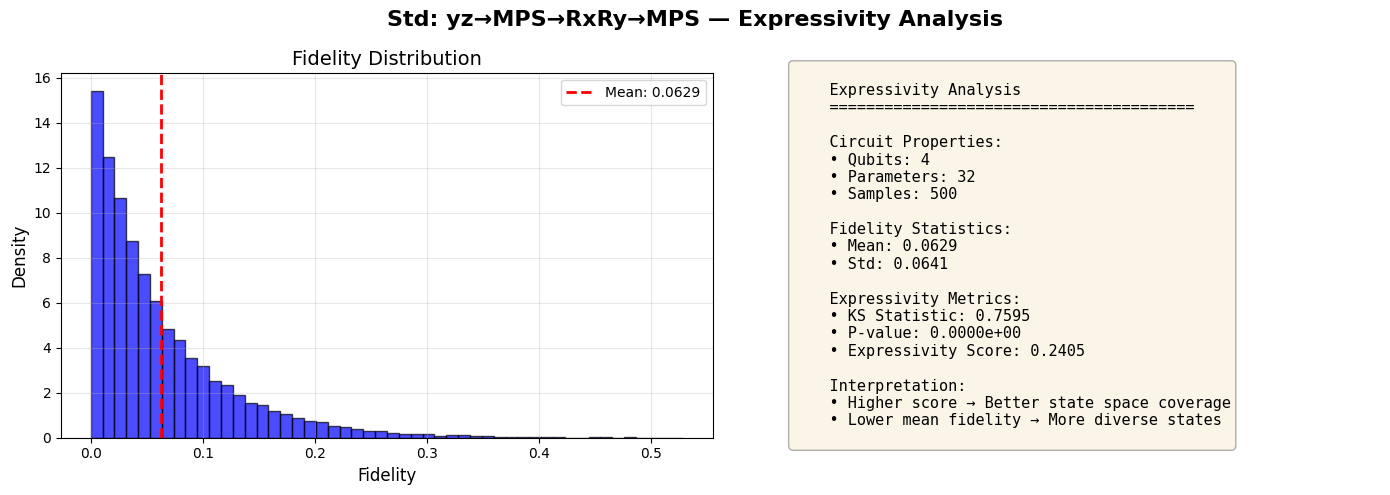

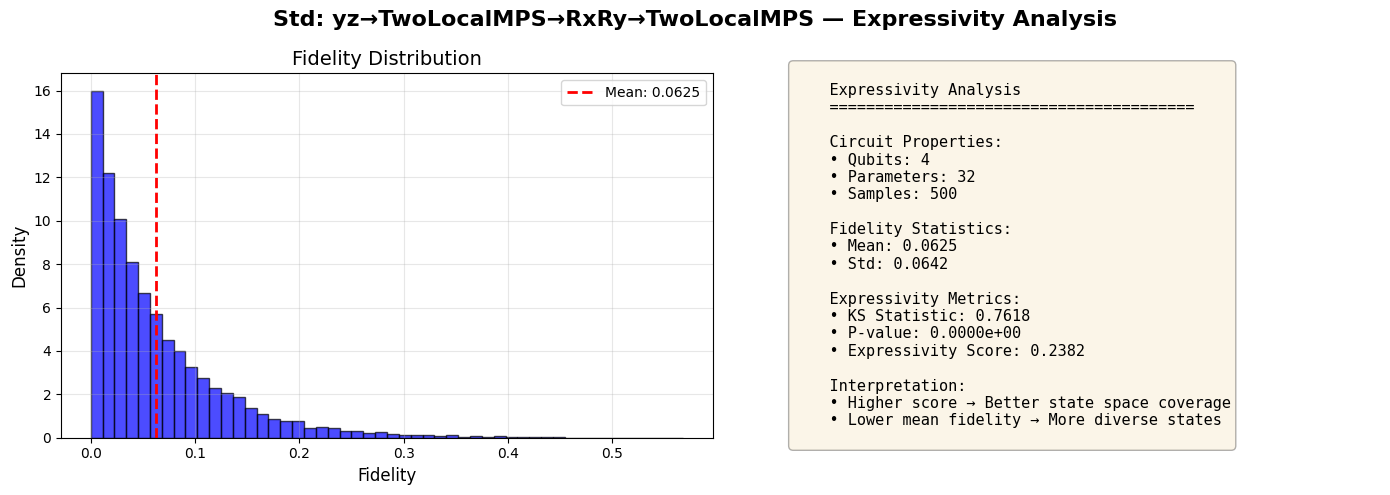

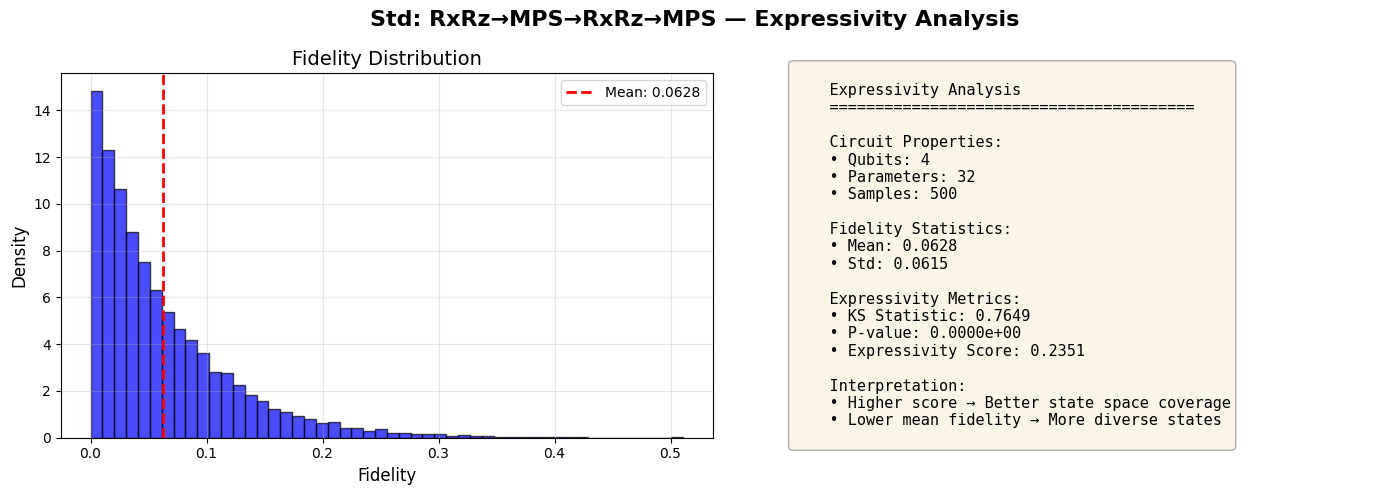

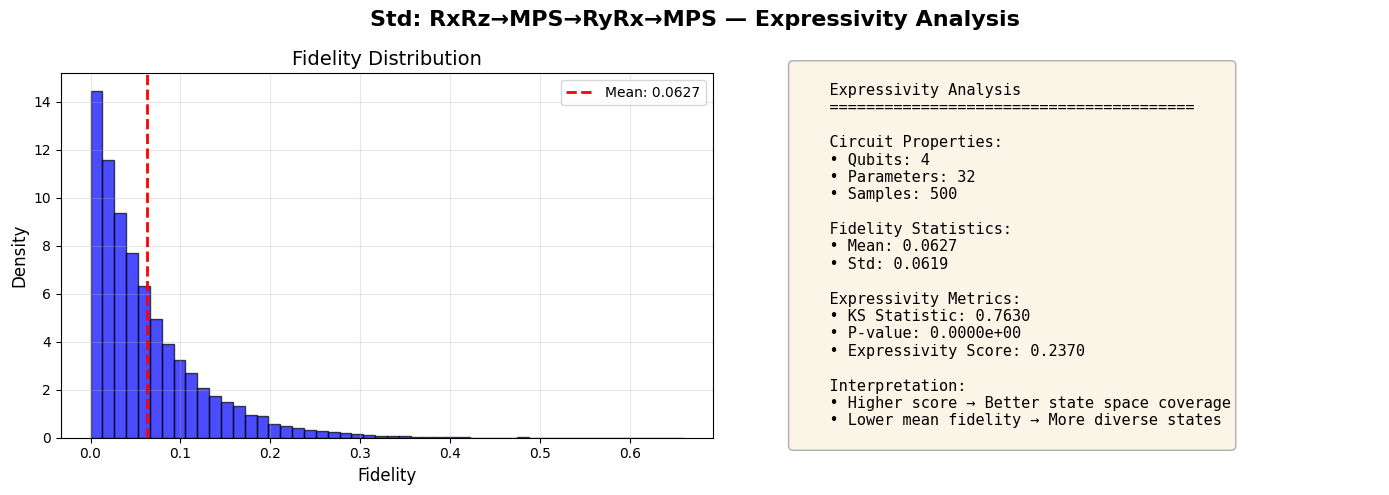

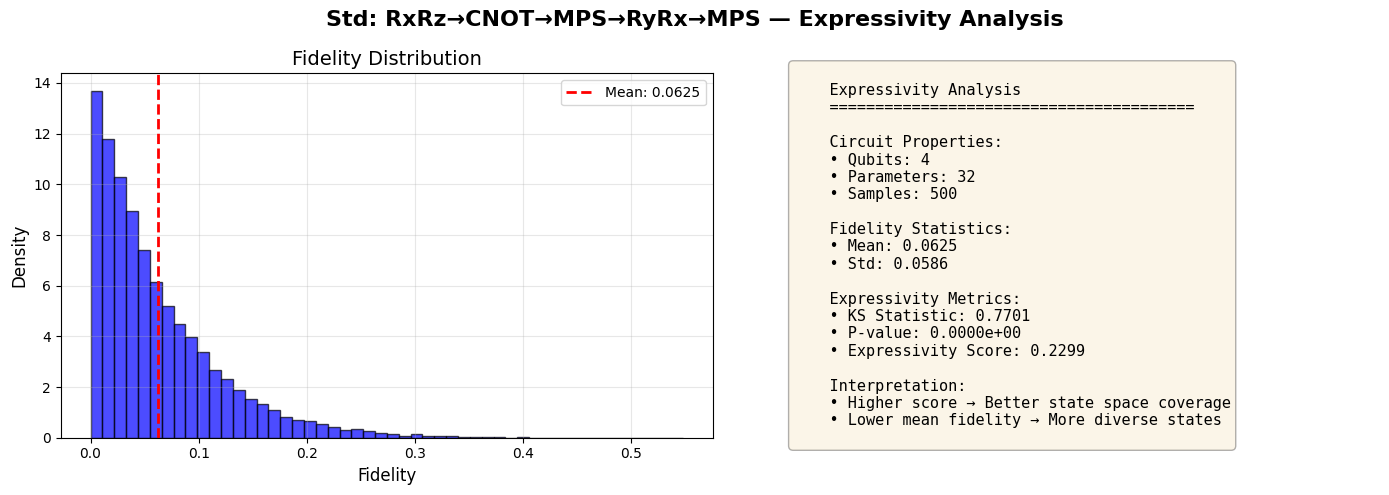

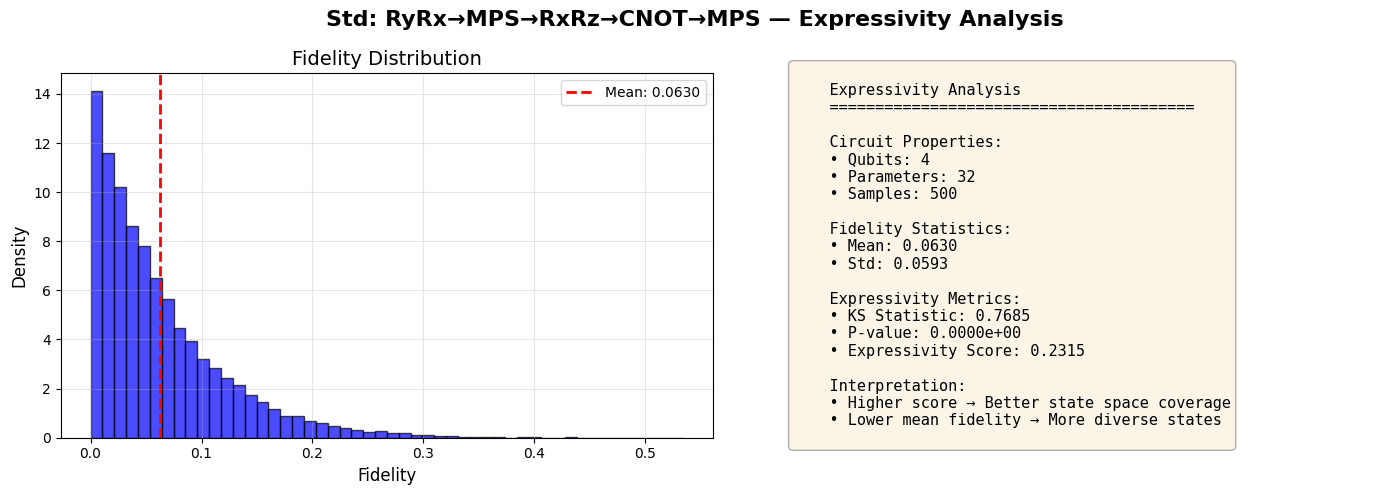

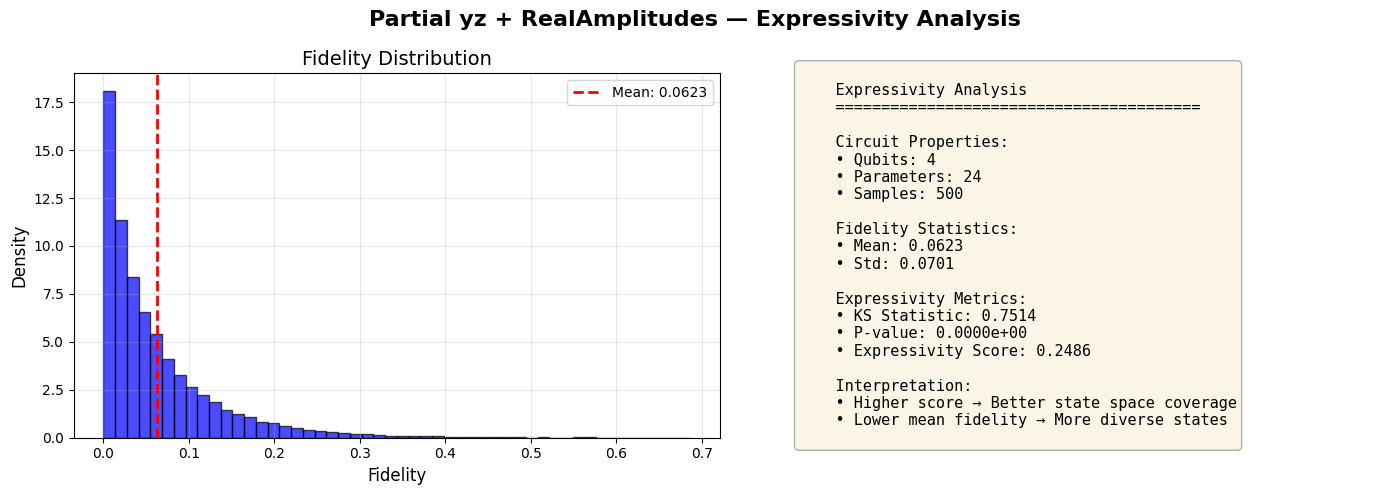

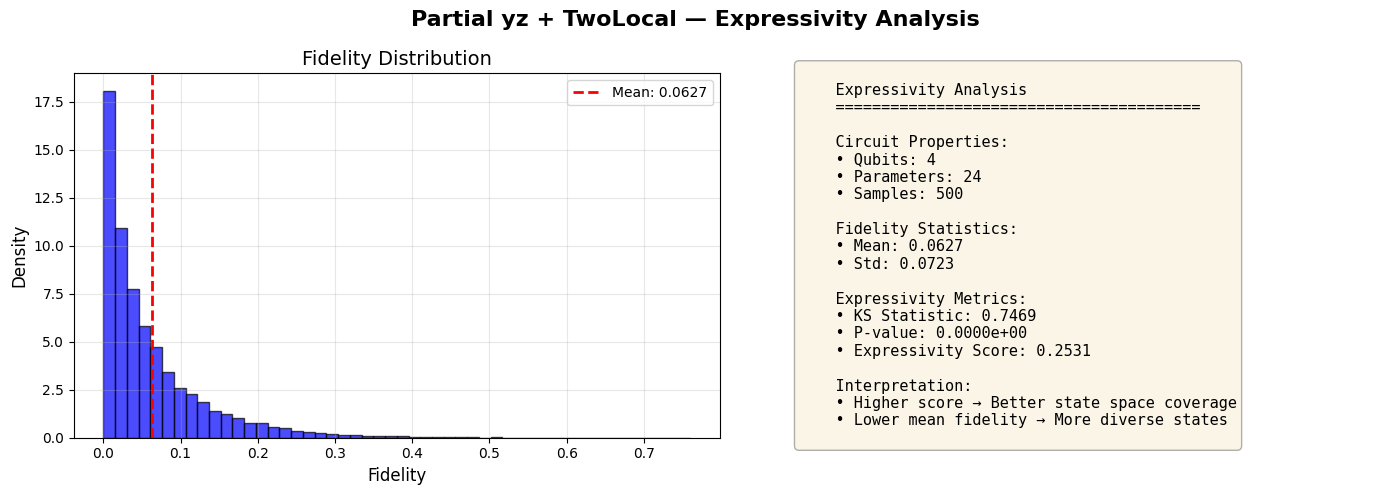

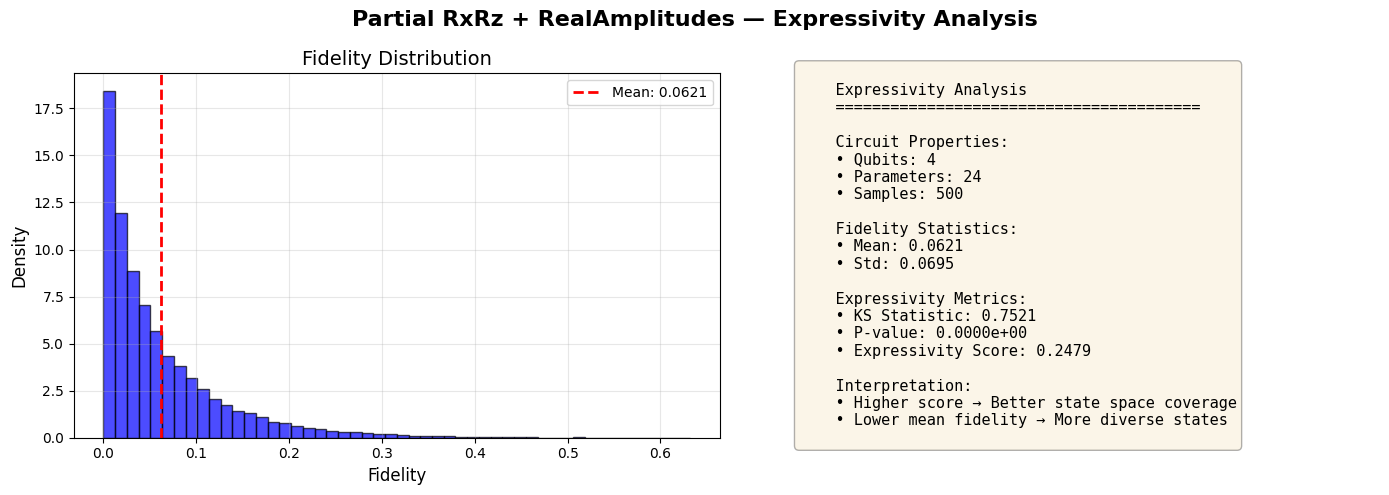

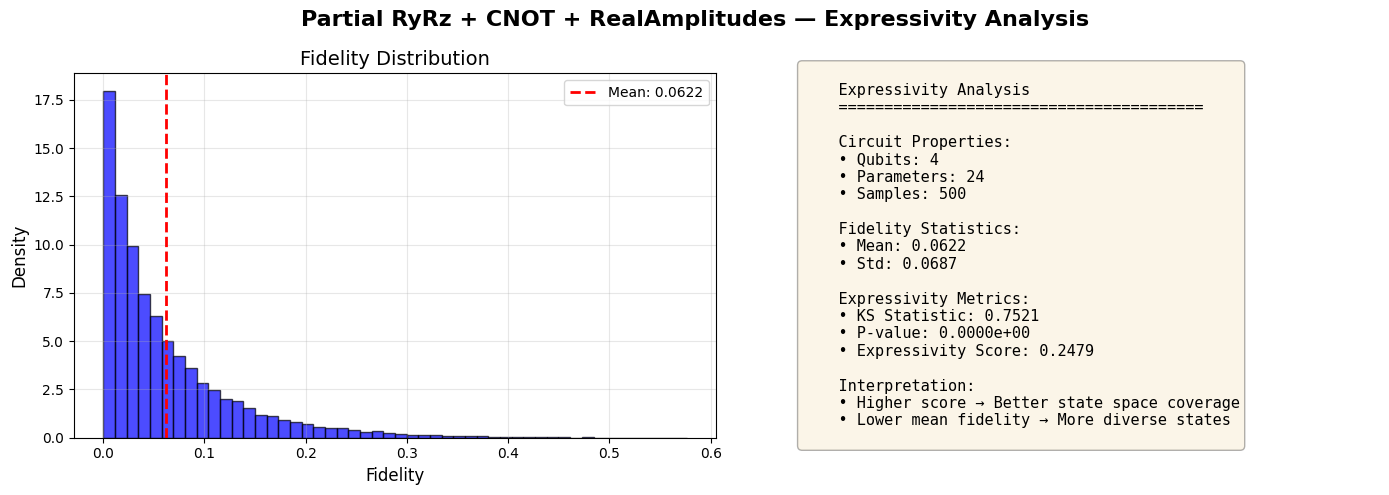

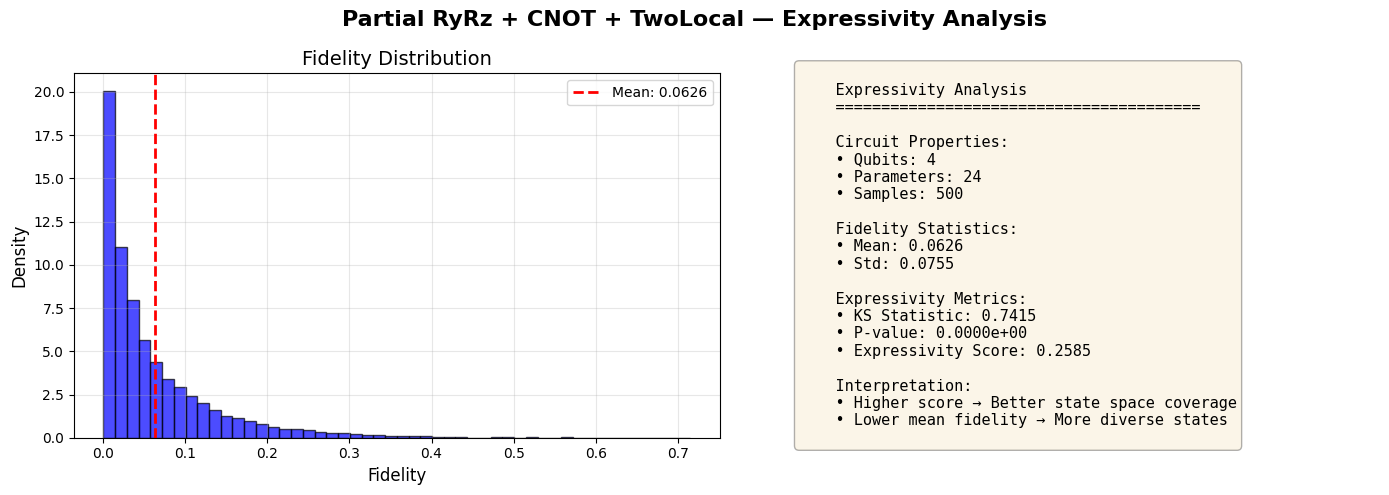

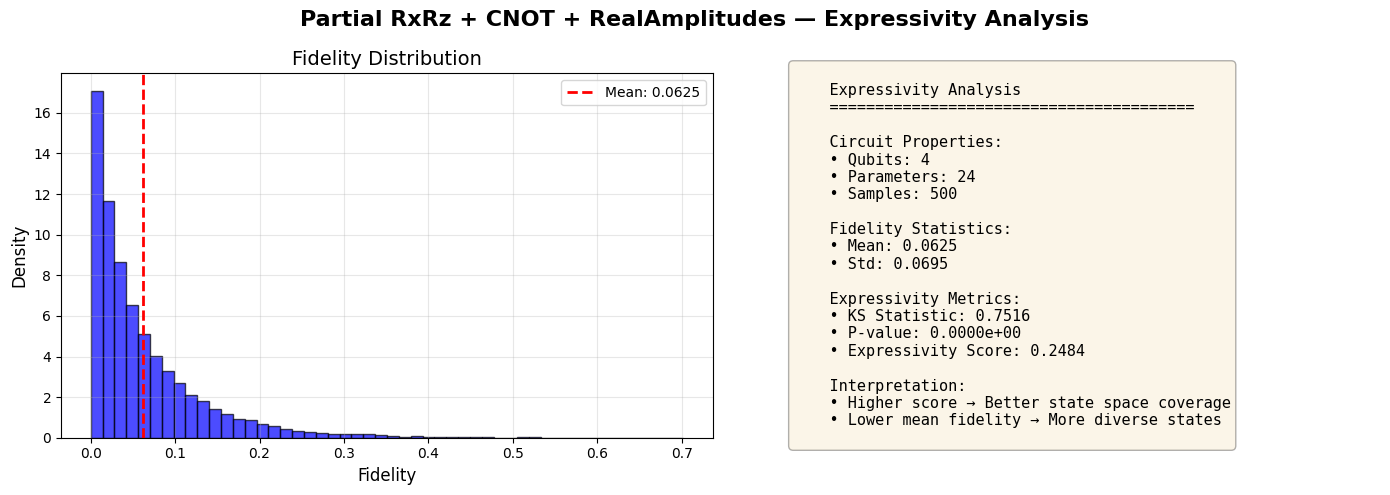

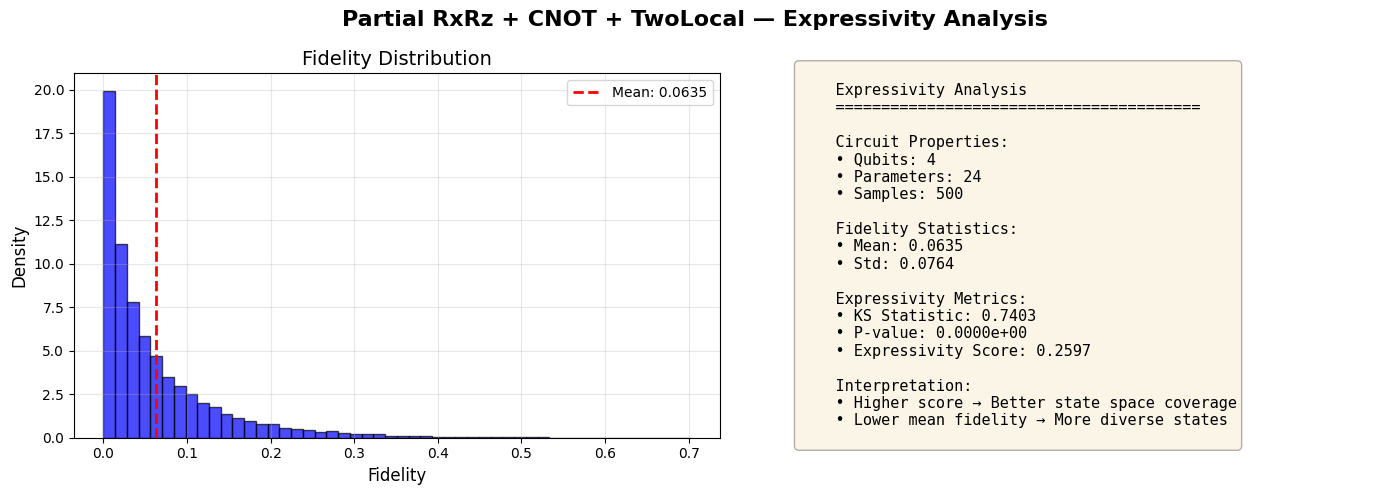

In [191]:
# Individual fidelity distribution plots for each architecture
for name, result in expressivity_results.items():
    plot_expressivity_results(result, title=f"{name} — Expressivity Analysis")

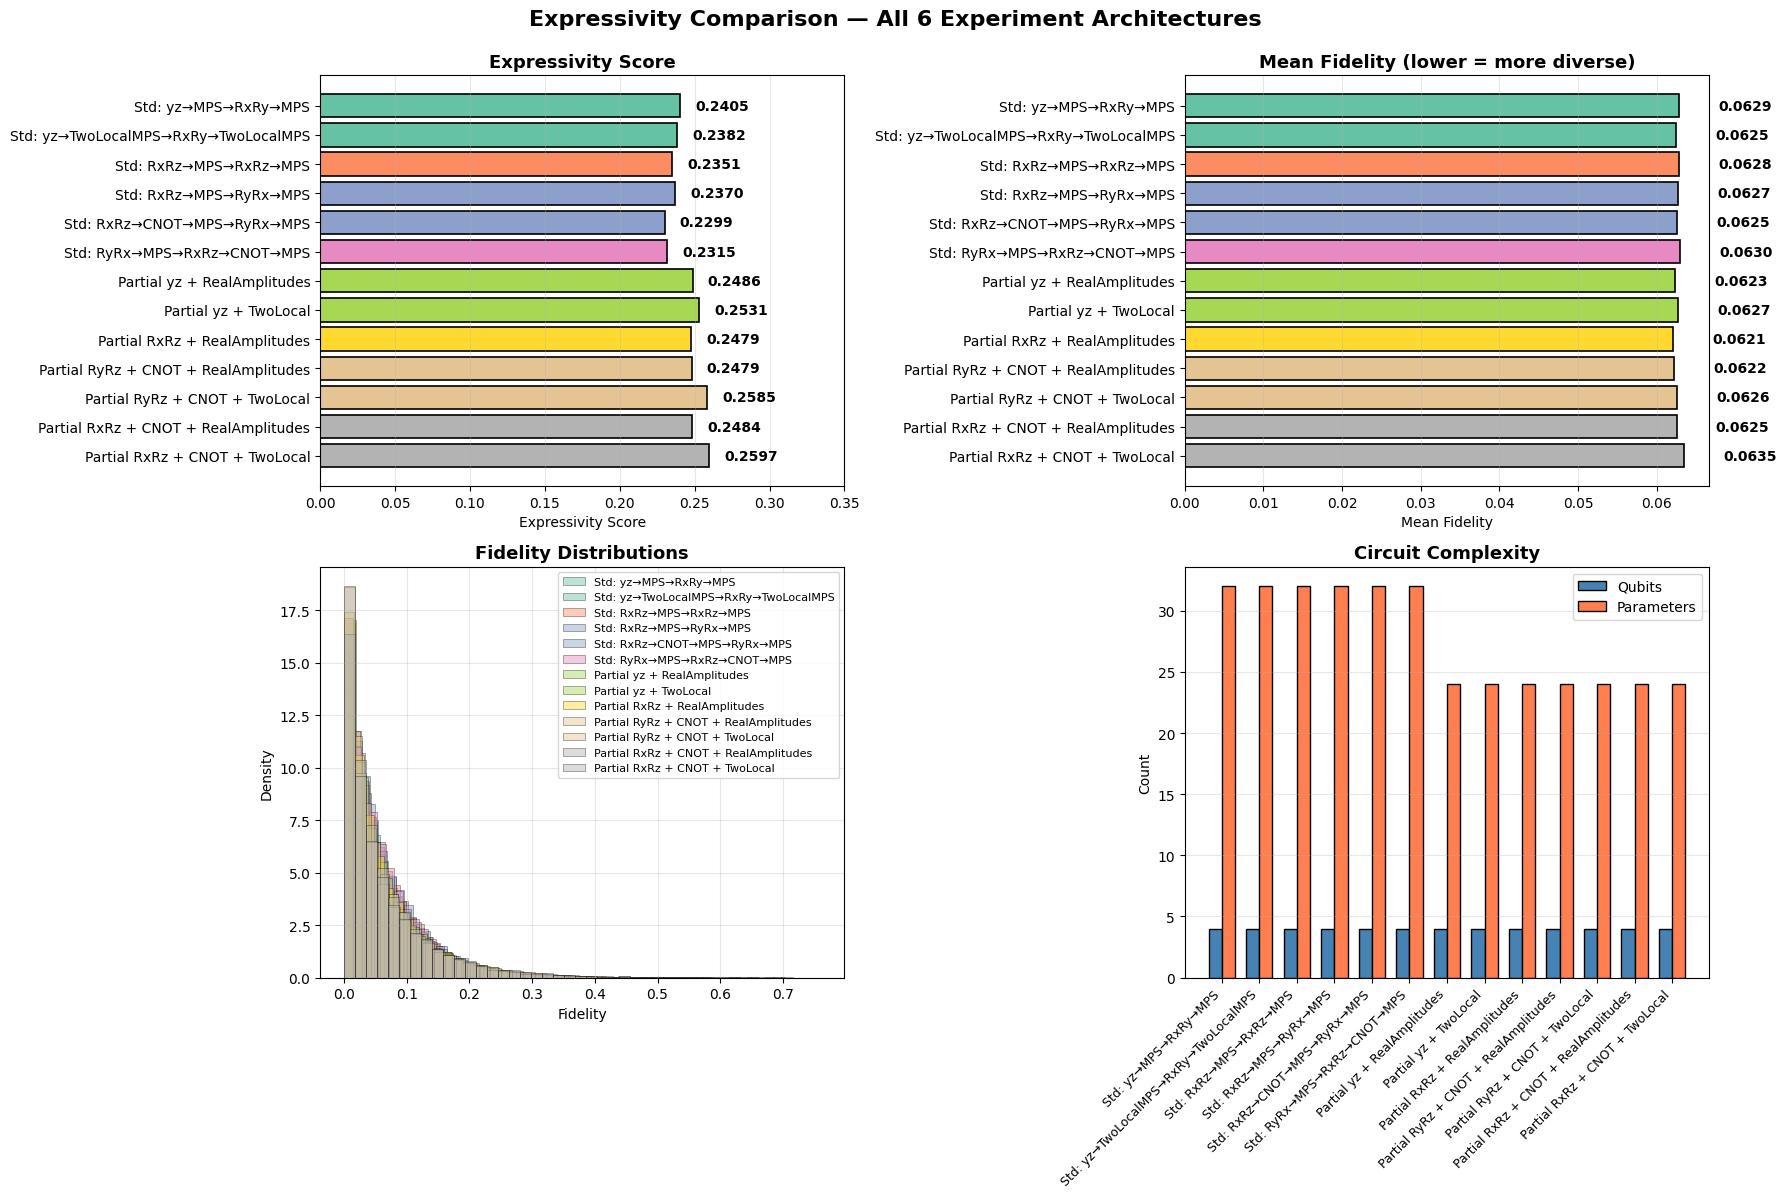


EXPRESSIVITY SUMMARY — 6 EXPERIMENT ARCHITECTURES
Architecture                              Qubits  Params  Expr Score   Mean Fid    Std Fid  Expr/Param
---------------------------------------------------------------------------------------------------------
Std: yz→MPS→RxRy→MPS                           4      32      0.2405     0.0629     0.0641      0.0075
Std: yz→TwoLocalMPS→RxRy→TwoLocalMPS           4      32      0.2382     0.0625     0.0642      0.0074
Std: RxRz→MPS→RxRz→MPS                         4      32      0.2351     0.0628     0.0615      0.0073
Std: RxRz→MPS→RyRx→MPS                         4      32      0.2370     0.0627     0.0619      0.0074
Std: RxRz→CNOT→MPS→RyRx→MPS                    4      32      0.2299     0.0625     0.0586      0.0072
Std: RyRx→MPS→RxRz→CNOT→MPS                    4      32      0.2315     0.0630     0.0593      0.0072
Partial yz + RealAmplitudes                    4      24      0.2486     0.0623     0.0701      0.0104
Partial yz + TwoLoc

In [200]:
# --- Comprehensive comparison of all 6 architectures ---
if len(expressivity_results) > 0:
    names  = list(expressivity_results.keys())
    scores = [expressivity_results[n]['expressivity_score'] for n in names]
    mean_f = [expressivity_results[n]['mean_fidelity']      for n in names]
    std_f  = [expressivity_results[n]['std_fidelity']       for n in names]
    n_par  = [expressivity_results[n]['num_params']         for n in names]
    n_qub  = [expressivity_results[n]['num_qubits']         for n in names]
    colors = plt.cm.Set2(np.linspace(0, 1, len(names)))

    # ---- Figure 1: Bar charts ----
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # Reverse order for visualization
    names_r  = names[::-1]
    scores_r = scores[::-1]
    mean_f_r = mean_f[::-1]
    colors_r = colors[::-1]

    # 1) Expressivity Score
    ax = axes[0, 0]
    bars = ax.barh(names_r, scores_r, color=colors_r, edgecolor='black', linewidth=1.2)
    for b, s in zip(bars, scores_r):
        ax.text(b.get_width() + 0.01, b.get_y() + b.get_height()/2,
                f'{s:.4f}', va='center', fontsize=10, fontweight='bold')
    ax.set_xlabel('Expressivity Score')
    ax.set_xlim([0, 0.35])
    ax.set_title('Expressivity Score', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

    # 2) Mean Fidelity
    ax = axes[0, 1]
    bars = ax.barh(names_r, mean_f_r, color=colors_r, edgecolor='black', linewidth=1.2)
    for b, m in zip(bars, mean_f_r):
        ax.text(b.get_width() + 0.005, b.get_y() + b.get_height()/2,
                f'{m:.4f}', va='center', fontsize=10, fontweight='bold')
    ax.set_xlabel('Mean Fidelity')
    ax.set_title('Mean Fidelity (lower = more diverse)', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

    # 3) Overlaid fidelity distributions
    ax = axes[1, 0]
    for name, c in zip(names, colors):
        fids = expressivity_results[name]['fidelities']
        ax.hist(fids, bins=40, density=True, alpha=0.45,
                label=name, color=c, edgecolor='black', linewidth=0.5)
    ax.set_xlabel('Fidelity')
    ax.set_ylabel('Density')
    ax.set_title('Fidelity Distributions', fontsize=13, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

    # 4) Circuit complexity (qubits + parameters)
    ax = axes[1, 1]
    x = np.arange(len(names))
    w = 0.35
    ax.bar(x - w/2, n_qub, w, label='Qubits',     color='steelblue', edgecolor='black')
    ax.bar(x + w/2, n_par, w, label='Parameters',  color='coral',     edgecolor='black')
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Count')
    ax.set_title('Circuit Complexity', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    plt.suptitle('Expressivity Comparison — All 6 Experiment Architectures',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

    # ---- Summary Table ----
    print("\n" + "=" * 105)
    print("EXPRESSIVITY SUMMARY — 6 EXPERIMENT ARCHITECTURES")
    print("=" * 105)
    print(f"{'Architecture':<40} {'Qubits':>7} {'Params':>7} "
          f"{'Expr Score':>11} {'Mean Fid':>10} {'Std Fid':>10} {'Expr/Param':>11}")
    print("-" * 105)
    for name in names:
        r = expressivity_results[name]
        expr_per_param = r['expressivity_score'] / r['num_params'] if r['num_params'] > 0 else 0
        print(f"{name:<40} {r['num_qubits']:>7} {r['num_params']:>7} "
              f"{r['expressivity_score']:>11.4f} {r['mean_fidelity']:>10.4f} "
              f"{r['std_fidelity']:>10.4f} {expr_per_param:>11.4f}")
    print("=" * 105)

### Expressivity Analysis — Interpretation

#### Metrics

| Metric | Meaning |
|---|---|
| **Expressivity Score** (0–1) | How uniformly the circuit covers the Hilbert space. Closer to 1 → better coverage (Haar-like). |
| **Mean Fidelity** | Average overlap between randomly generated states. Lower → more diverse states. |
| **Std Fidelity** | Spread of the fidelity distribution. |
| **Expr/Param** | Expressivity efficiency: expressivity score normalized by number of trainable parameters. |

### Training configuration

Initial configuration for model training procedure.

In [193]:
n_features = 8
if n_features == 8:
    model_to_train = qmodel_8
    distance_model = HybridRegressorConvNet8Features(model_to_train)
else:
    model_to_train = qmodel_12
    distance_model = HybridRegressorConvNet12Features(model_to_train)
training_dataloader = DataLoader(t, batch_size=8, shuffle=True)
val_data_loader = DataLoader(v, batch_size=8, shuffle=True)
distance_model = distance_model.to(device)
optimizer = torch.optim.SGD(distance_model.parameters(), lr=1e-2)
loss = torch.nn.TripletMarginLoss(margin=2)
epochs = 100

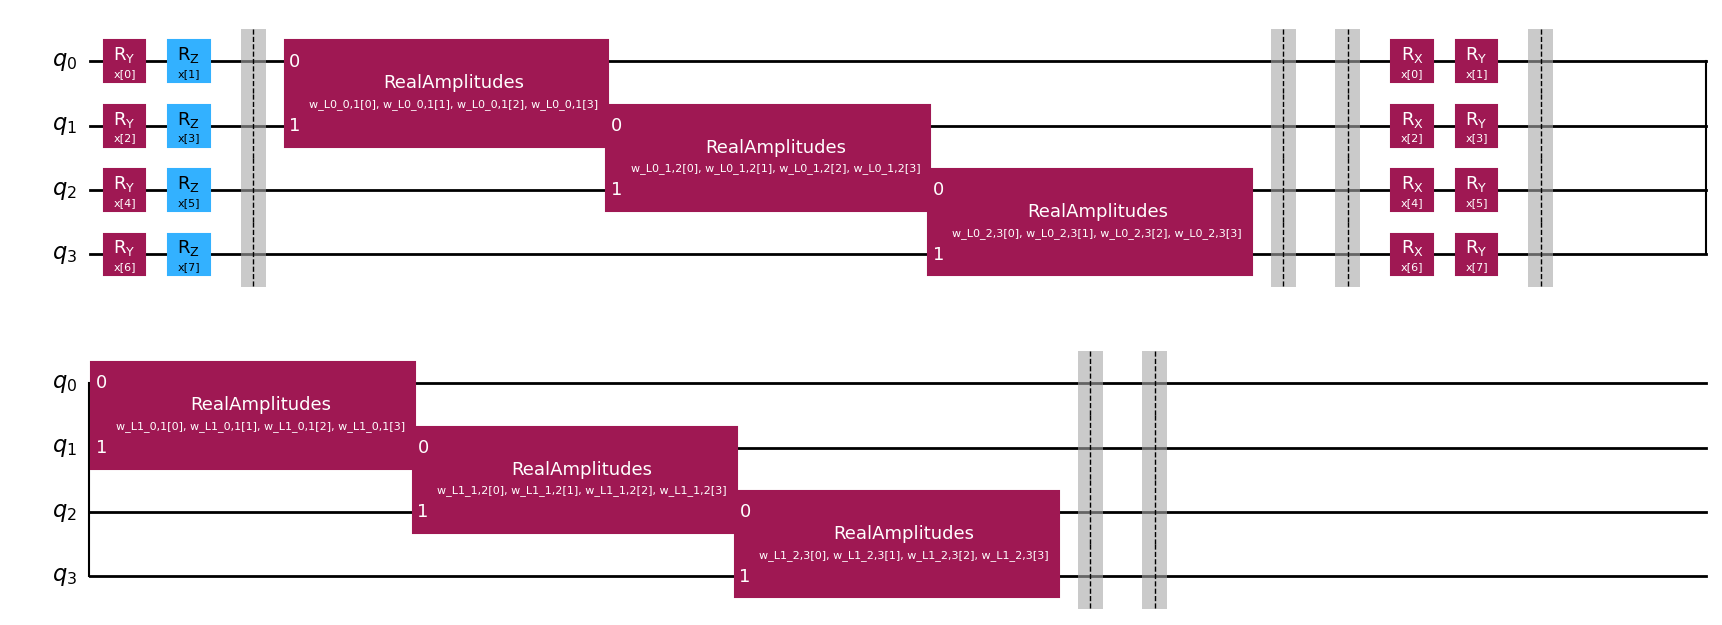

In [194]:
model_to_train.circuit.draw(output="mpl")

### Training loop

Main model training loop with standardized output formatting.

In [195]:
def train(model, epochs, optimizer, criterion, train_data_loader, val_data_loader, device, validation_step=False, print_at=1, seed=42):
    """
    Executes model training with standardized output formatting.
    
    Args:
        model: Neural network model to train
        epochs: Number of training epochs
        optimizer: Optimization algorithm
        criterion: Loss function
        train_data_loader: Training data loader
        val_data_loader: Validation data loader (optional)
        device: Computation device (CPU/GPU)
        validation_step: Whether to perform validation (default=False)
        print_at: Print frequency (every N epochs, default=1)
        seed: Random seed for reproducibility (default=42)
    
    Returns:
        model: Trained model
    """
    
    set_seed(seed)
    for epoch in range(epochs):
        set_seed(seed + epoch)
        
        prnt = (epoch % print_at) != 0 if epoch != (epochs - 1) else False
        
        if not prnt:
            print("\033[1mEpoch {}/{}\033[0m".format(epoch + 1, epochs))
        
        # --- Training Phase ---
        model.train()
        train_loss = 0.0
        train_samples = 0
        
        for anchor, positive, negative in tqdm(train_data_loader, disable=prnt):
            optimizer.zero_grad()
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            e_A = model(anchor)
            e_P = model(positive)
            e_N = model(negative)
            loss = criterion(e_A, e_P, e_N)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_samples += positive.size(0)
        train_loss /= len(train_data_loader)
        
        if not prnt:
            print(f"TRAINING | Loss: {train_loss:2.6f}")
            print("")

### Training loop with early stopping

Training loop with early stopping logic and automatic checkpointing mechanism.

In [196]:
def train(model, epochs, optimizer, criterion, train_data_loader, val_data_loader, device, 
          validation_step=False, print_at=1, early_stopping_patience=3, 
          min_delta=0.001, restore_best_weights=True, seed=42, 
          checkpoint_interval=100, checkpoint_path="model_results/triplet_loss"):
    """
    Training function with automatic checkpointing every N epochs and standardized output.
    
    Args:
        model: Neural network model to train
        epochs: Number of training epochs
        optimizer: Optimization algorithm
        criterion: Loss function
        train_data_loader: Training data loader
        val_data_loader: Validation data loader
        device: Computation device (CPU/GPU)
        validation_step: Whether to perform validation (default=False)
        print_at: Print frequency (default=1)
        early_stopping_patience: Patience for early stopping (default=3)
        min_delta: Minimum improvement threshold (default=0.001)
        restore_best_weights: Whether to restore best weights (default=True)
        seed: Random seed (default=42)
        checkpoint_interval: Checkpoint save frequency (default=100)
        checkpoint_path: Directory for saving checkpoints
    
    Returns:
        tuple: (trained_model, checkpoint_epochs, checkpoint_logs)
    """
    import os
    import time
    os.makedirs(checkpoint_path, exist_ok=True)

    # Initialize time tracking
    training_start_time = time.time()

    set_seed(seed)
    best_loss = float('inf')
    no_improvement_count = 0
    best_model_state = None
    checkpoint_epochs = []
    checkpoint_logs = {}  # Dictionary to save time and loss for each checkpoint

    for epoch in range(epochs):
        
        set_seed(seed + epoch)
        prnt = (epoch % print_at) != 0 if epoch != (epochs-1) else False

        # Initialize early_stopping_triggered at the beginning of each epoch
        early_stopping_triggered = False

        if not prnt:
            print(f"\033[1mEpoch {epoch+1}/{epochs}\033[0m")

        ### --> Training Phase
        model.train()
        train_loss = 0.0
        train_samples = 0

        for anchor, positive, negative in tqdm(train_data_loader, disable=prnt):
            optimizer.zero_grad()
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            e_A = model(anchor)
            e_P = model(positive)
            e_N = model(negative)

            loss = criterion(e_A, e_P, e_N)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_samples += positive.size(0)

        train_loss /= len(train_data_loader)
        
        ### --> Validation Phase (if requested)
        val_loss = 0.0
        if validation_step and not prnt:
            model.eval()
            with torch.no_grad():
                for anchor, positive, negative in val_data_loader:
                    anchor = anchor.to(device)
                    positive = positive.to(device)
                    negative = negative.to(device)

                    e_A = model(anchor)
                    e_P = model(positive)
                    e_N = model(negative)

                    loss = criterion(e_A, e_P, e_N)
                    val_loss += loss.item()

                val_loss /= len(val_data_loader)

        ### --> Early Stopping Logic
        if validation_step and not prnt:
            # Check for improvement
            if (best_loss - val_loss) > min_delta:
                best_epoch = epoch
                best_loss = val_loss
                no_improvement_count = 0
                # Save best model state
                if restore_best_weights:
                    print(f"Best epoch: {best_epoch+1}")
                    best_model_state = model.state_dict().copy()
            else:
                no_improvement_count += 1
                if no_improvement_count >= early_stopping_patience:
                    print(f"\n{color.RED}Early stopping at epoch {epoch+1}{color.END}")
                    early_stopping_triggered = True

        ### --> Print results
        if not prnt:
            log_str = f"TRAINING | Loss: {train_loss:2.6f}"
            if validation_step:
                log_str += f" | VALIDATION -> Loss: {val_loss:2.6f}"
            print(log_str)
            print("")

        ### --> Save checkpoint every checkpoint_interval epochs
        if (epoch + 1) % checkpoint_interval == 0:
            # Calculate total training time in minutes
            elapsed_time_minutes = (time.time() - training_start_time) / 60
            
            checkpoint_filename = f"{checkpoint_path}/checkpoint_epoch_{epoch+1}.pt"
            torch.save(model.state_dict(), checkpoint_filename)
            checkpoint_epochs.append(epoch + 1)
            
            # Save time and train loss for this checkpoint
            checkpoint_logs[epoch + 1] = {
                'training_time_minutes': elapsed_time_minutes,
                'train_loss': train_loss
            }
            
            print(f"{color.GREEN}Checkpoint saved: {checkpoint_filename}{color.END}")
            print(f"Training time: {elapsed_time_minutes:.2f} minutes")
            print(f"Train Loss: {train_loss:.6f}")
            print("")

        ### --> Stop training if early stopping triggered
        if early_stopping_triggered:
            break

    ### --> Restore best weights if requested
    if restore_best_weights and best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"{color.GREEN}Restored best model weights{color.END}")

    return model, checkpoint_epochs, checkpoint_logs

### Training execution

Training loop execution and checkpoint saving with standardized output.

In [197]:
# CHECKPOINT CONFIGURATION
CHECKPOINT_PATH = "model_results/triplet_loss/Standard"
CHECKPOINT_INTERVAL = 100  # Save every 100 epochs

# Training without Early Stopping
distance_model, checkpoint_epochs, checkpoint_logs = train(
    model=distance_model,
    epochs=200,
    optimizer=optimizer,
    criterion=loss,
    train_data_loader=training_dataloader,
    val_data_loader=None,
    validation_step=False,
    device=device,
    print_at=1,
    seed=42,
    checkpoint_interval=CHECKPOINT_INTERVAL,
    checkpoint_path=CHECKPOINT_PATH
)

# Save checkpoint logs for evaluation
CHECKPOINT_EVAL_LOGS = checkpoint_logs

print(f"\n{color.BOLD}Training completed{color.END}")
print(f"Checkpoints saved at epochs: {checkpoint_epochs}")


# Training with Early Stopping (commented out)
# distance_model, checkpoint_epochs, checkpoint_logs = train(
#     distance_model,
#     epochs=200,
#     optimizer=optimizer,
#     criterion=loss,
#     train_data_loader=training_dataloader,
#     val_data_loader=val_data_loader,
#     device=device,
#     validation_step=True,
#     early_stopping_patience=4,
#     min_delta=0.005,
#     seed=42,
#     checkpoint_interval=CHECKPOINT_INTERVAL,
#     checkpoint_path=CHECKPOINT_PATH
# )

Epoch 1/200


  5%|▌         | 2/38 [00:16<04:53,  8.15s/it]


KeyboardInterrupt: 

# AUTOMATIC CHECKPOINT EVALUATION ON TEST SET

Automatic performance evaluation of saved checkpoints on the test set with standardized output.

In [ ]:
import os
import glob

def evaluate_checkpoint_on_test(checkpoint_path, model_template, test_dataset, device, batch_size=128):
    """
    Loads a checkpoint and evaluates performance on the test set with standardized output.
    
    Args:
        checkpoint_path: Path to checkpoint file
        model_template: Model template for loading weights
        test_dataset: Test dataset
        device: Computation device
        batch_size: Batch size for evaluation (default=128)
    
    Returns:
        dict: Evaluation results dictionary
    """
    # Load checkpoint
    model_template.load_state_dict(torch.load(checkpoint_path))
    model_template.eval()
    
    # Generate embeddings for test set
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    test_embedding_data = np.empty((0, 16))
    
    with torch.no_grad():
        for anchor, _, _ in tqdm(test_loader, desc=f"Generating embeddings"):
            anchor = anchor.to(device)
            embeddings = model_template(anchor).to("cpu").numpy()
            test_embedding_data = np.concatenate((test_embedding_data, embeddings), axis=0)
    
    # Agglomerative Clustering
    agg_clustering = AgglomerativeClustering(n_clusters=10, linkage="average")
    agg_prediction = agg_clustering.fit_predict(test_embedding_data)
    agg_silhouette, agg_purity = evaluate_clustering_table(test_embedding_data, agg_prediction, test_dataset.target)
    
    # KMeans Clustering
    kmeans_clustering = KMeans(n_clusters=10, init="k-means++", n_init=10, random_state=42)
    kmeans_prediction = kmeans_clustering.fit_predict(test_embedding_data)
    kmeans_silhouette, kmeans_purity = evaluate_clustering_table(test_embedding_data, kmeans_prediction, test_dataset.target)
    
    return {
        'checkpoint': checkpoint_path,
        'test_embedding': test_embedding_data,
        'agg_silhouette': agg_silhouette,
        'agg_purity': agg_purity,
        'agg_prediction': agg_prediction,
        'kmeans_silhouette': kmeans_silhouette,
        'kmeans_purity': kmeans_purity,
        'kmeans_prediction': kmeans_prediction
    }

def evaluate_all_checkpoints(checkpoint_path, model_template, test_dataset, device):
    """
    Evaluates all saved checkpoints from training with standardized output.
    
    Args:
        checkpoint_path: Directory containing checkpoints
        model_template: Model template for loading weights
        test_dataset: Test dataset
        device: Computation device
    
    Returns:
        list: List of evaluation results for all checkpoints
    """
    # Find all checkpoints
    checkpoint_files = sorted(glob.glob(f"{checkpoint_path}/checkpoint_epoch_*.pt"))
    
    if not checkpoint_files:
        print(f"{color.RED}No checkpoints found in {checkpoint_path}{color.END}")
        return []
    
    print(f"\n{color.BOLD}=== CHECKPOINT EVALUATION ON TEST SET ==={color.END}")
    print(f"Found {len(checkpoint_files)} checkpoints to evaluate\n")
    
    results = []
    for checkpoint_file in checkpoint_files:
        # Extract epoch number from filename
        epoch_num = int(checkpoint_file.split('_')[-1].replace('.pt', ''))
        print(f"\n{color.CYAN}{'='*60}{color.END}")
        print(f"{color.BOLD}Checkpoint Epoch {epoch_num}{color.END}")
        print(f"{color.CYAN}{'='*60}{color.END}\n")
        
        result = evaluate_checkpoint_on_test(checkpoint_file, model_template, test_dataset, device)
        result['epoch'] = epoch_num
        results.append(result)
        
        # Print results with standardized formatting
        print(f"\n{color.GREEN}Test Set Results (10,000 samples):{color.END}")
        print(f"  Agglomerative Clustering:")
        print(f"    - Silhouette: {result['agg_silhouette']:.4f}")
        print(f"    - Purity:     {result['agg_purity']:.4f}")
        print(f"  KMeans Clustering:")
        print(f"    - Silhouette: {result['kmeans_silhouette']:.4f}")
        print(f"    - Purity:     {result['kmeans_purity']:.4f}")
    
    return results

# Prepare test dataset
t_test = MNIST_Distance_Dataset_Triplet_Loss(X_test, y_test)

# Evaluate all checkpoints
checkpoint_results = evaluate_all_checkpoints(
    checkpoint_path=CHECKPOINT_PATH,
    model_template=distance_model,
    test_dataset=t_test,
    device=device
)

In [ ]:
# Summary table of results with training time and train loss
print(f"\n{color.BOLD}{'='*100}{color.END}")
print(f"{color.BOLD}SUMMARY TABLE - CHECKPOINT COMPARISON {color.END}")
print(f"{color.BOLD}{'='*100}{color.END}\n")

# Header with training information
print(f"{'Epoch':<10} {'Train':<20} {'Agglomerative':<30} {'KMeans':<30}")
print(f"{'':10} {'Loss':<10} {'Time(min)':<10} {'Silhouette':<15} {'Purity':<15} {'Silhouette':<15} {'Purity':<15}")
print(f"{'-'*100}")

for result in checkpoint_results:
    epoch_num = result['epoch']
    
    # Get train loss and time if available
    train_loss_str = "N/A"
    train_time_str = "N/A"
    if 'CHECKPOINT_EVAL_LOGS' in globals() and epoch_num in CHECKPOINT_EVAL_LOGS:
        train_loss_str = f"{CHECKPOINT_EVAL_LOGS[epoch_num]['train_loss']:.4f}"
        train_time_str = f"{CHECKPOINT_EVAL_LOGS[epoch_num]['training_time_minutes']:.2f}"
    
    print(f"{epoch_num:<10} "
          f"{train_loss_str:<10} {train_time_str:<10} "
          f"{result['agg_silhouette']:<15.4f} {result['agg_purity']:<15.4f} "
          f"{result['kmeans_silhouette']:<15.4f} {result['kmeans_purity']:<15.4f}")

print(f"{'-'*100}\n")

# Identify best checkpoint for each metric
best_agg_sil = max(checkpoint_results, key=lambda x: x['agg_silhouette'])
best_agg_pur = max(checkpoint_results, key=lambda x: x['agg_purity'])
best_km_sil = max(checkpoint_results, key=lambda x: x['kmeans_silhouette'])
best_km_pur = max(checkpoint_results, key=lambda x: x['kmeans_purity'])

print(f"{color.GREEN}Best performance:{color.END}")
print(f"  Agglomerative Silhouette: Epoch {best_agg_sil['epoch']} ({best_agg_sil['agg_silhouette']:.4f})")
print(f"  Agglomerative Purity:     Epoch {best_agg_pur['epoch']} ({best_agg_pur['agg_purity']:.4f})")
print(f"  KMeans Silhouette:        Epoch {best_km_sil['epoch']} ({best_km_sil['kmeans_silhouette']:.4f})")
print(f"  KMeans Purity:            Epoch {best_km_pur['epoch']} ({best_km_pur['kmeans_purity']:.4f})")

In [ ]:
# Grafici comparativi delle metriche
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('Confronto Performance Checkpoint sul Test Set', fontsize=16, weight='bold')

epochs = [r['epoch'] for r in checkpoint_results]

# Train Loss (se disponibile)
if 'CHECKPOINT_EVAL_LOGS' in globals():
    train_losses = [CHECKPOINT_EVAL_LOGS.get(e, {}).get('train_loss', None) for e in epochs]
    if any(tl is not None for tl in train_losses):
        axes[0, 0].plot(epochs, train_losses, 
                       marker='*', linewidth=2, markersize=10, color='darkred')
        axes[0, 0].set_xlabel('Epoca', fontsize=12)
        axes[0, 0].set_ylabel('Train Loss', fontsize=12)
        axes[0, 0].set_title('Train Loss per Checkpoint', fontsize=14, weight='bold')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].set_xticks(epochs)

# Training Time (se disponibile)
if 'CHECKPOINT_EVAL_LOGS' in globals():
    train_times = [CHECKPOINT_EVAL_LOGS.get(e, {}).get('training_time_minutes', None) for e in epochs]
    if any(tt is not None for tt in train_times):
        axes[0, 1].plot(epochs, train_times, 
                       marker='o', linewidth=2, markersize=10, color='darkblue')
        axes[0, 1].set_xlabel('Epoca', fontsize=12)
        axes[0, 1].set_ylabel('Tempo (minuti)', fontsize=12)
        axes[0, 1].set_title('Tempo di Training Cumulativo', fontsize=14, weight='bold')
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].set_xticks(epochs)

# Agglomerative Silhouette
axes[1, 0].plot(epochs, [r['agg_silhouette'] for r in checkpoint_results], 
                marker='o', linewidth=2, markersize=8, color='steelblue')
axes[1, 0].set_xlabel('Epoca', fontsize=12)
axes[1, 0].set_ylabel('Silhouette Score', fontsize=12)
axes[1, 0].set_title('Agglomerative Clustering - Silhouette', fontsize=14, weight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(epochs)

# Agglomerative Purity
axes[1, 1].plot(epochs, [r['agg_purity'] for r in checkpoint_results], 
                marker='s', linewidth=2, markersize=8, color='seagreen')
axes[1, 1].set_xlabel('Epoca', fontsize=12)
axes[1, 1].set_ylabel('Purity Score', fontsize=12)
axes[1, 1].set_title('Agglomerative Clustering - Purity', fontsize=14, weight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(epochs)

# KMeans Silhouette
axes[2, 0].plot(epochs, [r['kmeans_silhouette'] for r in checkpoint_results], 
                marker='^', linewidth=2, markersize=8, color='coral')
axes[2, 0].set_xlabel('Epoca', fontsize=12)
axes[2, 0].set_ylabel('Silhouette Score', fontsize=12)
axes[2, 0].set_title('KMeans Clustering - Silhouette', fontsize=14, weight='bold')
axes[2, 0].grid(True, alpha=0.3)
axes[2, 0].set_xticks(epochs)

# KMeans Purity
axes[2, 1].plot(epochs, [r['kmeans_purity'] for r in checkpoint_results], 
                marker='D', linewidth=2, markersize=8, color='mediumpurple')
axes[2, 1].set_xlabel('Epoca', fontsize=12)
axes[2, 1].set_ylabel('Purity Score', fontsize=12)
axes[2, 1].set_title('KMeans Clustering - Purity', fontsize=14, weight='bold')
axes[2, 1].grid(True, alpha=0.3)
axes[2, 1].set_xticks(epochs)

plt.tight_layout()
plt.show()

In [ ]:
# Visualizzazione t-SNE per tutti i checkpoint confrontati con KMeans
num_checkpoints = len(checkpoint_results)
fig, axes = plt.subplots(1, num_checkpoints, figsize=(10 * num_checkpoints, 8))

if num_checkpoints == 1:
    axes = [axes]

fig.suptitle('Confronto Clustering KMeans tra Checkpoint (t-SNE Visualization)', 
             fontsize=16, weight='bold')

for idx, result in enumerate(checkpoint_results):
    # Applica t-SNE agli embedding
    reduction_model = TSNE(n_components=2, perplexity=30, random_state=42)
    vis_embed = reduction_model.fit_transform(result['test_embedding'])
    
    # Visualizza il clustering
    axes[idx].scatter(vis_embed[:, 0], vis_embed[:, 1], 
                     c=result['kmeans_prediction'], cmap='Dark2', alpha=0.6, s=10)
    axes[idx].set_title(f"Epoca {result['epoch']}\n"
                       f"Silhouette: {result['kmeans_silhouette']:.4f} | "
                       f"Purity: {result['kmeans_purity']:.4f}",
                       fontsize=12, weight='bold')
    axes[idx].set_xlabel('t-SNE Dim 1')
    axes[idx].set_ylabel('t-SNE Dim 2')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Save results to file for reference
import json
from datetime import datetime

results_summary = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'test_samples': len(t_test),
    'checkpoints': []
}

for result in checkpoint_results:
    epoch_num = result['epoch']
    checkpoint_entry = {
        'epoch': epoch_num,
        'agglomerative': {
            'silhouette': float(result['agg_silhouette']),
            'purity': float(result['agg_purity'])
        },
        'kmeans': {
            'silhouette': float(result['kmeans_silhouette']),
            'purity': float(result['kmeans_purity'])
        }
    }
    
    # Add training time and train loss if available
    if 'CHECKPOINT_EVAL_LOGS' in globals() and epoch_num in CHECKPOINT_EVAL_LOGS:
        checkpoint_entry['training_time_minutes'] = CHECKPOINT_EVAL_LOGS[epoch_num]['training_time_minutes']
        checkpoint_entry['train_loss'] = CHECKPOINT_EVAL_LOGS[epoch_num]['train_loss']
    
    results_summary['checkpoints'].append(checkpoint_entry)

# Save to JSON
results_file = f"{CHECKPOINT_PATH}/evaluation_results.json"
with open(results_file, 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"\n{color.GREEN}Results saved to: {results_file}{color.END}")
print(f"\n{color.BOLD}Information saved for each checkpoint:{color.END}")
print(f"  - Clustering metrics (Silhouette and Purity)")
print(f"  - Training time (minutes)")
print(f"  - Train Loss")